# install libraries  

https://colab.research.google.com/github/optuna/optuna-examples/blob/main/quickstart.ipynb#scrollTo=ZeLjs3VZVQUZ

In [1]:
!pip install --quiet optuna
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 58.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 115.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.1 MB/s eta 0:00:00


In [2]:
!pip install --upgrade torch transformers optuna

In [3]:
import optuna

optuna.__version__

'3.3.0'

In [4]:
import torch
import torch.nn as nn

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [5]:
torch.cuda.empty_cache()

In [6]:
import torch

num_gpus = torch.cuda.device_count()
print(f"Number of GPUs: {num_gpus}")

for i in range(num_gpus):
    gpu_name = torch.cuda.get_device_name(i)
    print(f"GPU {i}: {gpu_name}")


Number of GPUs: 1
GPU 0: NVIDIA A100-SXM4-40GB


In [7]:
import os

num_cpus = os.cpu_count()
print(f"Number of CPUs: {num_cpus}")

Number of CPUs: 12


In [8]:
!nvidia-smi

Thu Sep 21 20:48:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    50W / 400W |      3MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [10]:
torch.cuda.is_available()

True

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
# import tensorflow as tf
import pandas as pd
import numpy as np
import time
import datetime
import matplotlib.pyplot as plt
import collections
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader,RandomSampler,SequentialSampler,random_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, BatchNormalization, Dropout,Bidirectional
from transformers import BertForSequenceClassification, AdamW, BertConfig
from sklearn.metrics import confusion_matrix
import random
import seaborn as sns
import optuna
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import XLMRobertaForSequenceClassification, XLMRobertaTokenizer
import torch
import torch.nn as nn

In [13]:
# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [14]:
from transformers import AutoTokenizer  # Or BertTokenizer
from transformers import AutoModel  # or BertModel, for BERT without pretraining heads

#model = AutoModelForPreTraining.from_pretrained('neuralmind/bert-large-portuguese-cased')
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')

In [15]:
data = pd.read_csv('/content/drive/MyDrive/MS DATA SCIENCE /TESE /data_processed_selected.csv')
# data= pd.read_csv('/content/drive/MyDrive/data_processed_selected.csv')

# functions

In [16]:
# Tokenize sentences and create input tensors
def tokenize_text(text, max_len, tokenizer):
  encoded_dict = tokenizer.encode_plus(
                          text,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          # Add empty tokens if len(text)<MAX_LEN
                          padding = 'max_length',
                          # Truncate all sentences to max length
                          truncation=True,
                          max_length = max_len,           # Pad & truncate all sentences.
                          pad_to_max_length = True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )
  input_ids = encoded_dict['input_ids']
  attention_mask = encoded_dict['attention_mask']
  return input_ids, attention_mask

In [17]:
def create_tensors(X_train,X_val,X_test, max_len, tokenizer):
  train_inputs = []
  val_inputs = []
  test_inputs = []

  for sentence in X_train:
      input_ids, attention_mask = tokenize_text(sentence, max_len, tokenizer)
      train_inputs.append((input_ids, attention_mask))

  for sentence in X_val:
      input_ids, attention_mask = tokenize_text(sentence, max_len, tokenizer)
      val_inputs.append((input_ids, attention_mask))

  for sentence in X_test:
      input_ids, attention_mask = tokenize_text(sentence, max_len, tokenizer)
      test_inputs.append((input_ids, attention_mask))

  # Create input tensors and labels
  train_input_ids = torch.cat([t[0] for t in train_inputs], dim=0)
  train_attention_masks = torch.cat([t[1] for t in train_inputs], dim=0)
  train_labels = torch.tensor(y_train)

  val_input_ids = torch.cat([t[0] for t in val_inputs], dim=0)
  val_attention_masks = torch.cat([t[1] for t in val_inputs], dim=0)
  val_labels = torch.tensor(y_val)

  test_input_ids = torch.cat([t[0] for t in test_inputs], dim=0)
  test_attention_masks = torch.cat([t[1] for t in test_inputs], dim=0)
  test_labels = torch.tensor(y_test)

  train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
  val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
  test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)
  return train_dataset,val_dataset,test_dataset

In [18]:
# The DataLoader needs to know our batch size for training, so we specify it
# here. For fine-tuning BERT on a specific task, the authors recommend a batch
# size of 16 or 32.
def create_dataloaders(train_dataset,val_dataset,test_dataset, batch_s):
  batch_size = batch_s
  train_dataloader = DataLoader(train_dataset, sampler = SequentialSampler(train_dataset), batch_size=batch_size)
  validation_dataloader = DataLoader(val_dataset, sampler = SequentialSampler(val_dataset), batch_size=batch_size)
  test_dataloader = DataLoader(test_dataset, sampler = SequentialSampler(test_dataset), batch_size=batch_size)

  print(len(train_dataset))
  print(len(val_dataset))
  print(len(test_dataset))
  return train_dataloader,validation_dataloader,test_dataloader

In [19]:
def load_data(batch_s, max_len, tokenizer):
  train_dataset,val_dataset,test_dataset=create_tensors(X_train,X_val,X_test, max_len, tokenizer)
  train_dataloader, validation_dataloader, test_dataloader= create_dataloaders(train_dataset,val_dataset,test_dataset, batch_s=batch_s)
  return train_dataloader,validation_dataloader

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
def train(model, optimizer, scheduler, train_dataloader, validation_dataloader, epochs, early_stopping_patience=3):
# A value of 3 for early_stopping_patience means that if the validation loss does not improve for three consecutive epochs, the training will stop early.
  # We'll store a number of quantities such as training and validation loss,
  # validation accuracy, and timings.
  training_stats = []

  # Variables for early stopping
  best_val_loss = np.Inf
  epochs_without_improvement = 0

  # For each epoch...
  for epoch_i in range(0, epochs):

      # ========================================
      #               Training
      # ========================================

      # Perform one full pass over the training set.

      # Reset the total loss for this epoch.
      total_train_loss = 0

      valid_loss_min = np.Inf

      model.train()

      # For each batch of training data...
      for batch in train_dataloader:

        # Unpack this training batch from our dataloader.
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass.
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        result = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels,
                        return_dict=True)

        loss = result.loss
        logits = result.logits


        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

      # Calculate the average loss over all of the batches.
      # average training loss
      avg_train_loss = total_train_loss / len(train_dataloader)

      # ========================================
      #               Validation
      # ========================================
      # After the completion of each training epoch, measure our performance on
      # our validation set.

      # Put the model in evaluation mode
      model.eval()

      # Tracking variables
      total_eval_accuracy = 0
      total_eval_loss = 0
      nb_eval_steps = 0

      # Evaluate data for one epoch
      for batch in validation_dataloader:

          # Unpack this training batch from our dataloader.
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)

          # Tell pytorch not to bother with constructing the compute graph during
          # the forward pass, since this is only needed for backprop (training).
          with torch.no_grad():

              # Forward pass, calculate logit predictions.
              result = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels=b_labels,
                            return_dict=True)

          # Get the loss and "logits" output by the model. The "logits" are the
          # output values prior to applying an activation function like the
          # softmax.
          loss = result.loss
          logits = result.logits

          # Accumulate the validation loss.
          total_eval_loss += loss.item()

          # Move logits and labels to CPU
          logits = logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()

          # Calculate the accuracy for this batch of test sentences, and
          # accumulate it over all batches.
          total_eval_accuracy += flat_accuracy(logits, label_ids)


      # Report the final accuracy for this validation run.
      avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)

      # Calculate the average loss over all of the batches.
      # validation loss
      avg_val_loss = total_eval_loss / len(validation_dataloader)

      # Save the model if the validation loss is the best so far
      if avg_val_loss < best_val_loss:
          best_val_loss = avg_val_loss
          epochs_without_improvement = 0
          # Save the model state (optional, you can decide when to save)
          torch.save(model.state_dict(), 'best_model_state.pth')
      else:
          epochs_without_improvement += 1
          if epochs_without_improvement >= early_stopping_patience:
              print(f'Early stopping triggered after {epoch_i + 1} epochs.')
              break

  return best_val_loss

# description

In [ ]:
# identify features and target
sentences = data.narrative_bert.values
labels = data.reason.values

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.3, stratify=labels, random_state=42)

# Split the remaining data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

In [ ]:
import os

# Replace '/content/drive/MyDrive/OptunaStudies/' with your desired path in Google Drive
# google_drive_path = '/content/drive/MyDrive/MS DATA SCIENCE /TESE /bert_optuna/'
google_drive_path = '/content/drive/MyDrive/bert_optuna/'
database_filename = 'description.db'

# Full path to the SQLite database file in Google Drive
database_path = os.path.join(google_drive_path, database_filename)

# Set the SQLite database path to Google Drive path
storage = optuna.storages.RDBStorage(url=f'sqlite:///{database_path}')

In [ ]:
import optuna

def objective(trial):
  max_len= trial.suggest_categorical ('max_len',[64, 128, 256])
  weight_decay=trial.suggest_float('weight_decay',1e-6, 1e-1)
  lr=trial.suggest_float('lr',1e-7, 1e-2)
  epochs = trial.suggest_int('epochs', 4, 16)
  batch_s=trial.suggest_categorical ('batch_size',[8, 16, 32])
  warmup_steps=trial.suggest_categorical('warmup_steps',[0.1,0.2,0.3])
  tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
  train_loader, val_loader = load_data(batch_s=batch_s, max_len=max_len, tokenizer=tokenizer)  # Load some data
  model = model = BertForSequenceClassification.from_pretrained("neuralmind/bert-base-portuguese-cased",
                                                                num_labels = 4,
                                                                output_attentions = False, # Whether the model returns attentions weights.
                                                                output_hidden_states = False, # Whether the model returns all hidden-states
  )
  model.to(device)
  optimizer = AdamW(model.parameters(),
                    lr=lr,
                    weight_decay=weight_decay)


  total_steps = len(train_loader) * epochs

  # Create the learning rate scheduler.
  scheduler = get_linear_schedule_with_warmup(optimizer,
                                              num_warmup_steps=int(warmup_steps*total_steps), #0 # Default value in run_glue.py
                                              num_training_steps=total_steps)

  val_loss = train(model, optimizer, scheduler, train_loader, val_loader, epochs)

  # Report the validation loss for the current trial
  trial.report(val_loss, step=trial.number)

  # If trial should be pruned based on early stopping logic
  if trial.should_prune():
      raise optuna.TrialPruned()

  return val_loss

In [ ]:
import multiprocessing
import torch

# Get the number of CPU cores
num_cpu_cores = multiprocessing.cpu_count()

# Get the number of available GPUs
num_gpus = torch.cuda.device_count()

print(f"Number of CPU cores: {num_cpu_cores}")
print(f"Number of available GPUs: {num_gpus}")

Number of CPU cores: 2
Number of available GPUs: 1


In [ ]:
study = optuna.create_study(storage=storage, direction='minimize', study_name='description',load_if_exists=True)
study.optimize(objective, n_trials=100)

trial = study.best_trial
print('Val Loss: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2023-07-26 17:11:52,599] A new study created in RDB with name: description


15701
3364
3365


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Early stopping triggered after 4 epochs.


[I 2023-07-26 17:46:46,597] Trial 0 finished with value: 1.091974305656721 and parameters: {'batch_size': 32, 'epochs': 8, 'lr': 0.0011537315708340186, 'max_len': 64, 'warmup_steps': 0.3, 'weight_decay': 0.053073550673004434}. Best is trial 0 with value: 1.091974305656721.


15701
3364
3365


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Early stopping triggered after 6 epochs.


[I 2023-07-26 19:45:41,844] Trial 1 finished with value: 1.1316016514624099 and parameters: {'batch_size': 8, 'epochs': 5, 'lr': 0.003607967908761051, 'max_len': 64, 'warmup_steps': 0.2, 'weight_decay': 0.03195668066585315}. Best is trial 0 with value: 1.091974305656721.


15701
3364
3365


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# in case it fails
# Load the existing study by providing the study name and storage URL
study = optuna.load_study(study_name='description', storage=storage)

# Continue optimization with additional trials
study.optimize(objective, n_trials=100)

trial = study.best_trial
print('Val Loss: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

In [ ]:
study = optuna.load_study(study_name='description', storage=storage)
trial = study.best_trial
print('Val Loss: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))
optuna.visualization.plot_optimization_history(study)

Val Loss: 0.8600619809245164
Best hyperparameters: {'max_len': 128, 'weight_decay': 0.07559054336016528, 'lr': 8.23828987673291e-06, 'epochs': 15, 'batch_size': 32, 'warmup_steps': 0.2}


In [ ]:
trials = study.trials_dataframe()
print(len(trials[trials.state == "COMPLETE"]))

In [ ]:
optuna.visualization.plot_param_importances(study)

# retraining best model

In [ ]:
# https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb#scrollTo=mjJGEXShp7te
from transformers import BertForSequenceClassification
import torch.nn as nn

model = BertForSequenceClassification.from_pretrained(
    "neuralmind/bert-base-portuguese-cased",
    num_labels=4,
    output_attentions=False,
    output_hidden_states=False
)

# Tell PyTorch to run the model on the GPU
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [20]:
from transformers import AdamW, get_linear_schedule_with_warmup

def set_configs(model, train_dataloader,learning_rate=8.23828987673291e-06, epochs=15, weight_decay=0.07559054336016528):
    # Note: AdamW is a class from the huggingface library (as opposed to pytorch)
    # I believe the 'W' stands for 'Weight Decay fix"
    optimizer = AdamW(model.parameters(),
                      lr=learning_rate, #lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                      weight_decay=weight_decay)

    # Total number of training steps is [number of batches] x [number of epochs].
    # (Note that this is not the same as the number of training samples).
    total_steps = len(train_dataloader) * epochs # bert recommends between 2 and 4

    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_training_steps=total_steps,
                                                num_warmup_steps=0.2*total_steps)

    return optimizer, scheduler

In [21]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [22]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

def get_metrics(predictions,true_labels):
  # Combine the results across all batches.
  flat_predictions = np.concatenate(predictions, axis=0)

  # For each sample, pick the label (0 or 1) with the higher score.
  flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

  # Combine the correct labels for each batch into a single list.
  flat_true_labels = np.concatenate(true_labels, axis=0)

  cr = classification_report(flat_true_labels, flat_predictions)
  print('CLASSIFICATION REPORT')
  print(cr)
  print('\n')
  print('CONFUSION MATRIX')
  cf=confusion_matrix(flat_true_labels, flat_predictions, labels=[0,1,2,3])
  # Print the confusion matrix using Matplotlib
  fig, ax = plt.subplots(figsize=(7.5, 7.5))
  ax.matshow(cf, cmap=plt.cm.Blues, alpha=0.3)
  for i in range(cf.shape[0]):
      for j in range(cf.shape[1]):
          ax.text(x=j, y=i,s=cf[i, j], va='center', ha='center', size='xx-large')
  plt.xlabel('Predictions', fontsize=18)
  plt.ylabel('Actuals', fontsize=18)
  plt.title('Confusion Matrix', fontsize=18)
  plt.show()
  print('\n')

In [23]:
import time
import torch
import numpy as np

def train(model, optimizer, scheduler, train_dataloader, validation_dataloader, epochs):

  # We'll store a number of quantities such as training and validation loss,
  # validation accuracy, and timings.
  training_stats = []

  # Measure the total training time for the whole run.
  total_t0 = time.time()

  best_val_loss = np.Inf
  patience_counter = 0
  patience_limit = 3

  # For each epoch...
  for epoch_i in range(0, epochs):

      # ========================================
      #               Training
      # ========================================

      # Perform one full pass over the training set.

      print("")
      print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
      print('Training...')

      # Measure how long the training epoch takes.
      t0 = time.time()

      # Reset the total loss for this epoch.
      total_train_loss = 0

      valid_loss_min = np.Inf

      model.train()

      # For each batch of training data...
      for step, batch in enumerate(train_dataloader):

          # Progress update every 50 batches.
          if step % 50 == 0 and not step == 0:
              # Calculate elapsed time in minutes.
              elapsed = format_time(time.time() - t0)

              # Report progress.
              print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

          # Unpack this training batch from our dataloader.
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)

          # Always clear any previously calculated gradients before performing a
          # backward pass.
          model.zero_grad()

          # Perform a forward pass (evaluate the model on this training batch).
          result = model(b_input_ids,
                          token_type_ids=None,
                          attention_mask=b_input_mask,
                          labels=b_labels,
                          return_dict=True)

          loss = result.loss
          logits = result.logits


          # Accumulate the training loss over all of the batches so that we can
          # calculate the average loss at the end. `loss` is a Tensor containing a
          # single value; the `.item()` function just returns the Python value
          # from the tensor.
          total_train_loss += loss.item()

          # Perform a backward pass to calculate the gradients.
          loss.backward()

          # Clip the norm of the gradients to 1.0.
          # This is to help prevent the "exploding gradients" problem.
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          # Update parameters and take a step using the computed gradient.
          optimizer.step()

          # Update the learning rate.
          scheduler.step()

      # Calculate the average loss over all of the batches.
      avg_train_loss = total_train_loss / len(train_dataloader)

      # Measure how long this epoch took.
      training_time = format_time(time.time() - t0)

      print("")
      print("  Average training loss: {0:.2f}".format(avg_train_loss))
      print("  Training epoch took: {:}".format(training_time))

      # ========================================
      #               Validation
      # ========================================
      # After the completion of each training epoch, measure our performance on
      # our validation set.

      print("")
      print("Running Validation...")

      t0 = time.time()

      # Put the model in evaluation mode
      model.eval()

      # Tracking variables
      total_eval_accuracy = 0
      total_eval_loss = 0
      nb_eval_steps = 0
      predictions, true_labels=[],[]

      # Evaluate data for one epoch
      for batch in validation_dataloader:

          # Unpack this training batch from our dataloader.
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)

          # Tell pytorch not to bother with constructing the compute graph during
          # the forward pass, since this is only needed for backprop (training).
          with torch.no_grad():

              # Forward pass, calculate logit predictions.
              result = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels=b_labels,
                            return_dict=True)

          # Get the loss and "logits" output by the model. The "logits" are the
          # output values prior to applying an activation function like the
          # softmax.
          loss = result.loss
          logits = result.logits

          # Accumulate the validation loss.
          total_eval_loss += loss.item()

          # Move logits and labels to CPU
          logits = logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()


          # Calculate the accuracy for this batch of test sentences, and
          # accumulate it over all batches.
          total_eval_accuracy += flat_accuracy(logits, label_ids)

          predictions.append(logits)
          true_labels.append(label_ids)

      # Report the final accuracy for this validation run.
      avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
      print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

      # Calculate the average loss over all of the batches.
      avg_val_loss = total_eval_loss / len(validation_dataloader)

      # Early stopping check
      if avg_val_loss < best_val_loss:
          print('Saving model')
          torch.save(model.state_dict(), 'saved_weights_bertimbau.pt')
          best_val_loss = avg_val_loss
          patience_counter = 0
      else:
          patience_counter += 1

      if patience_counter >= patience_limit:
          print(f'Early stopping at epoch {epoch_i+1} due to no improvement in validation loss.')
          break

      # Measure how long the validation run took.
      validation_time = format_time(time.time() - t0)

      print("  Validation Loss: {0:.2f}".format(avg_val_loss))
      print("  Validation took: {:}".format(validation_time))

      # Record all statistics from this epoch.
      training_stats.append(
          {
              'epoch': epoch_i + 1,
              'Training Loss': avg_train_loss,
              'Valid. Loss': avg_val_loss,
              'Valid. Accur.': avg_val_accuracy,
              'Training Time': training_time,
              'Validation Time': validation_time
          }
      )

  print("")
  print("Training complete!")

  print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
  print("Validation statistics \n")
  print(get_metrics(predictions,true_labels))
  return training_stats


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

def stats(training_stats, epochs):
  # Display floats with two decimal places.
  pd.set_option("display.precision", 2)
  # pd.set_option('precision', 2)

  # Create a DataFrame from our training statistics.
  df_stats = pd.DataFrame(data=training_stats)

  # Use the 'epoch' as the row index.
  df_stats = df_stats.set_index('epoch')

  # A hack to force the column headers to wrap.
  #df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

  # Display the table.
  df_stats

  # Use plot styling from seaborn.
  sns.set(style='darkgrid')

  # Increase the plot size and font size.
  sns.set(font_scale=1.5)
  plt.rcParams["figure.figsize"] = (12,6)

  # Plot the learning curve.
  plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
  plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

  # Label the plot.
  plt.title("Training & Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()

  xticks = list(range(1, epochs + 1))
  plt.xticks(xticks)
  plt.show()

In [25]:
def test(model, test_dataloader):
    print('Predicting labels for {:,} test sentences...'.format(len(test_dataset)))

    # Put model in evaluation mode
    model.eval()

    # Tracking variables
    predictions, true_labels = [], []

    # Predict
    for batch in test_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients, saving memory and
        # speeding up prediction
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            result = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           return_dict=True)

        logits = result.logits

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)

    print('    DONE.')

    return predictions, true_labels


In [ ]:
train_dataset,val_dataset,test_dataset=create_tensors(X_train,X_val,X_test,128,tokenizer)
train_dataloader, validation_dataloader, test_dataloader= create_dataloaders(train_dataset,val_dataset,test_dataset, batch_s=32)

15701
3364
3365


In [ ]:
optimizer1, scheduler1 = set_configs(model, train_dataloader, learning_rate=8.23828987673291e-06, epochs=15, weight_decay=0.07559054336016528)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



======== Epoch 1 / 15 ========
Training...
  Batch    50  of    491.    Elapsed: 0:00:14.
  Batch   100  of    491.    Elapsed: 0:00:25.
  Batch   150  of    491.    Elapsed: 0:00:35.
  Batch   200  of    491.    Elapsed: 0:00:46.
  Batch   250  of    491.    Elapsed: 0:00:57.
  Batch   300  of    491.    Elapsed: 0:01:08.
  Batch   350  of    491.    Elapsed: 0:01:19.
  Batch   400  of    491.    Elapsed: 0:01:30.
  Batch   450  of    491.    Elapsed: 0:01:40.

  Average training loss: 1.18
  Training epoch took: 0:01:49

Running Validation...
  Accuracy: 0.61
Saving model
  Validation Loss: 1.02
  Validation took: 0:00:08

======== Epoch 2 / 15 ========
Training...
  Batch    50  of    491.    Elapsed: 0:00:11.
  Batch   100  of    491.    Elapsed: 0:00:22.
  Batch   150  of    491.    Elapsed: 0:00:32.
  Batch   200  of    491.    Elapsed: 0:00:43.
  Batch   250  of    491.    Elapsed: 0:00:54.
  Batch   300  of    491.    Elapsed: 0:01:04.
  Batch   350  of    491.    Elapsed: 0:0

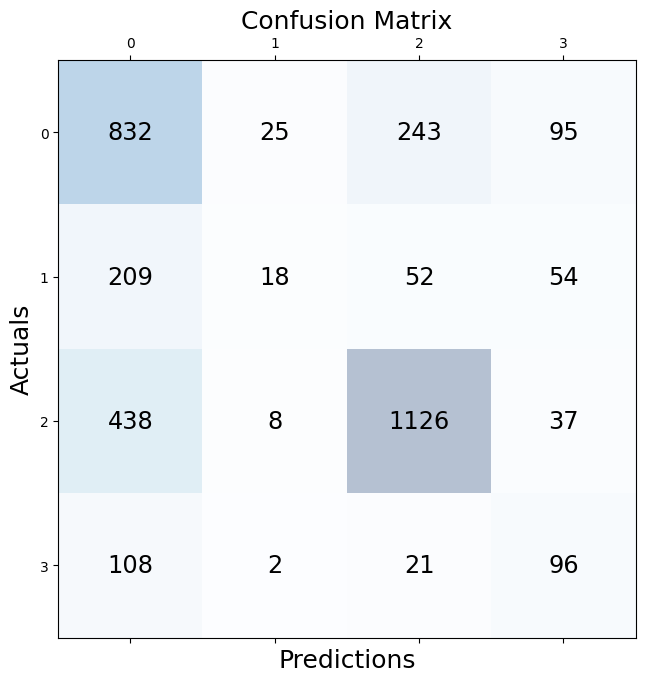



None


In [ ]:
training_stats= train(model, optimizer1, scheduler1, train_dataloader, validation_dataloader, epochs=15)

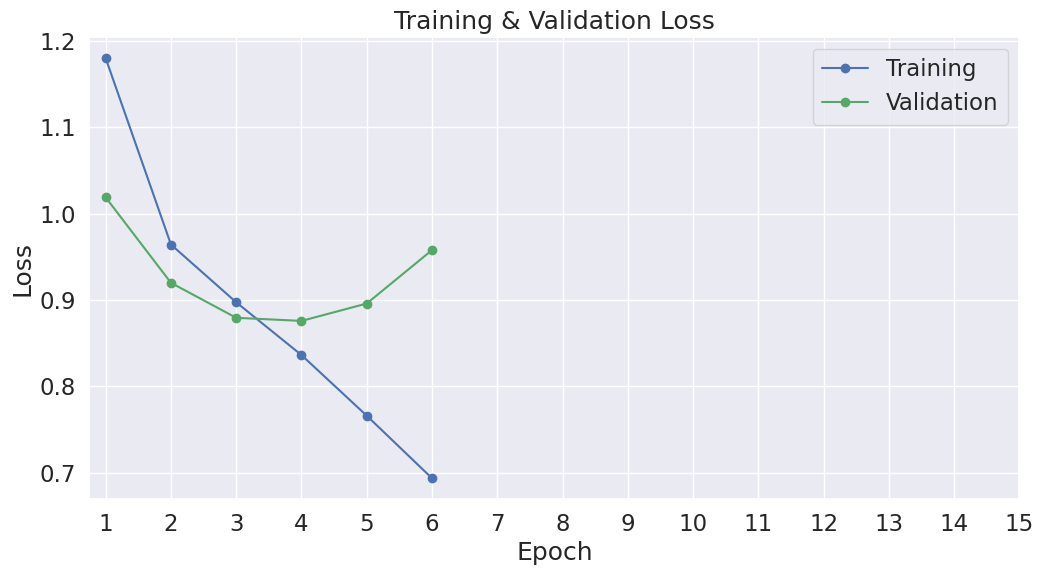

In [ ]:
stats(training_stats,15)

without early stopping

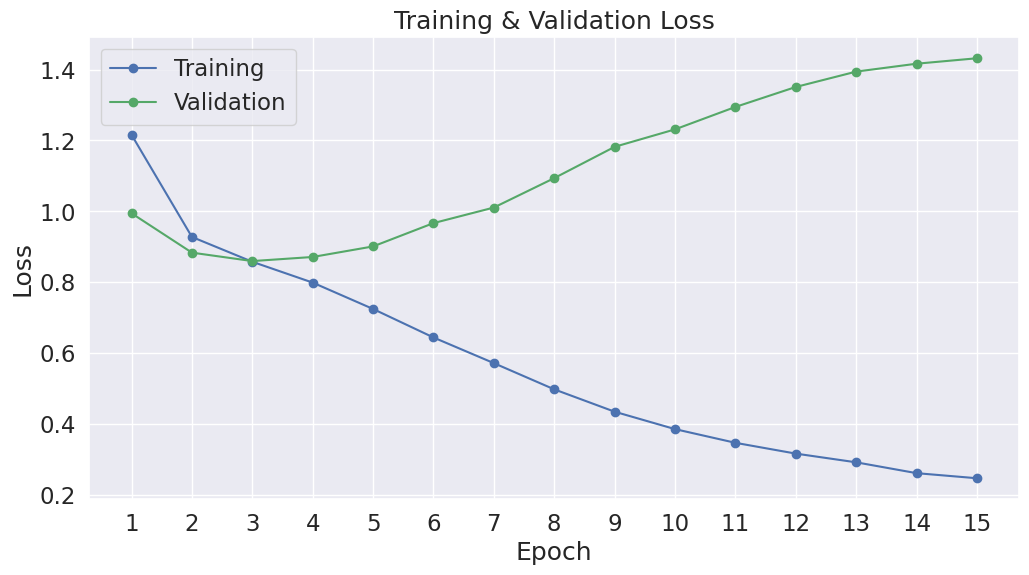

In [ ]:
# stats(training_stats,15)

In [ ]:
# Load best model
path='saved_weights_bertimbau.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
predictions, true_labels= test(model, test_dataloader)

Predicting labels for 3,365 test sentences...
    DONE.


In [ ]:
predictions_concatenated = np.concatenate(predictions)
print(len(predictions_concatenated))
true_labels_concatenated = np.concatenate(true_labels)
print(len(true_labels_concatenated))

3365
3365


CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.57      0.63      0.60      1195
           1       1.00      0.00      0.01       333
           2       0.72      0.85      0.78      1609
           3       0.41      0.27      0.33       228

    accuracy                           0.65      3365
   macro avg       0.68      0.44      0.43      3365
weighted avg       0.67      0.65      0.61      3365



CONFUSION MATRIX


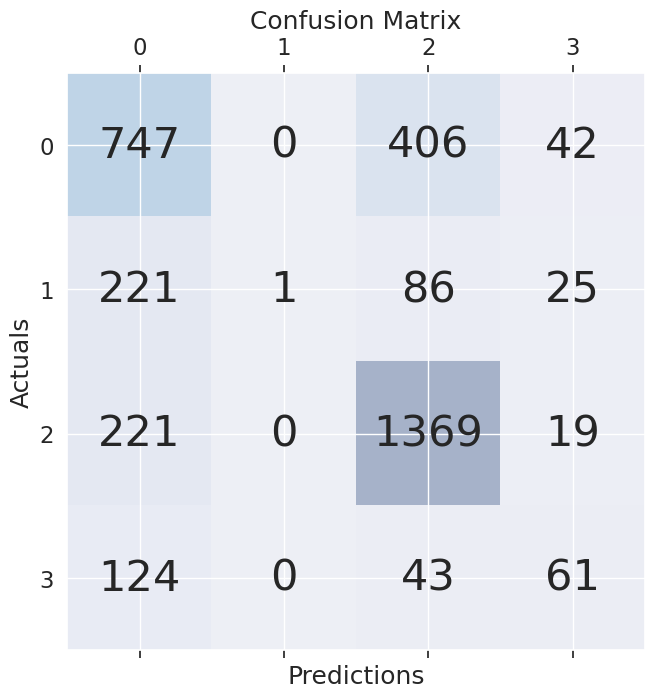

In [ ]:
get_metrics(predictions,true_labels)

# add 0.3 dropout to the best model

In [ ]:
from transformers import BertModel, BertForSequenceClassification, BertConfig

# Load the existing model configuration
config = BertConfig.from_pretrained(
    "neuralmind/bert-base-portuguese-cased",
    num_labels=4,
    output_attentions=False,
    output_hidden_states=False
)

# Adjust dropout rates as needed
config.hidden_dropout_prob = 0.3  # before 0.1
config.attention_probs_dropout_prob = 0.3  # before 0.1

# Create the modified BertForSequenceClassification model
model = BertForSequenceClassification(config)

model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.3, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
train_dataset,val_dataset,test_dataset=create_tensors(X_train,X_val,X_test,128,tokenizer)
train_dataloader, validation_dataloader, test_dataloader= create_dataloaders(train_dataset,val_dataset,test_dataset, batch_s=32)

15701
3364
3365


In [ ]:
optimizer1, scheduler1 = set_configs(model, train_dataloader, learning_rate=8.23828987673291e-06, epochs=15, weight_decay=0.07559054336016528)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



======== Epoch 1 / 15 ========
Training...
  Batch    50  of    491.    Elapsed: 0:00:11.
  Batch   100  of    491.    Elapsed: 0:00:21.
  Batch   150  of    491.    Elapsed: 0:00:32.
  Batch   200  of    491.    Elapsed: 0:00:44.
  Batch   250  of    491.    Elapsed: 0:00:55.
  Batch   300  of    491.    Elapsed: 0:01:06.
  Batch   350  of    491.    Elapsed: 0:01:17.
  Batch   400  of    491.    Elapsed: 0:01:28.
  Batch   450  of    491.    Elapsed: 0:01:38.

  Average training loss: 1.19
  Training epoch took: 0:01:47

Running Validation...
  Accuracy: 0.48
Saving model
  Validation Loss: 1.18
  Validation took: 0:00:10

======== Epoch 2 / 15 ========
Training...
  Batch    50  of    491.    Elapsed: 0:00:11.
  Batch   100  of    491.    Elapsed: 0:00:22.
  Batch   150  of    491.    Elapsed: 0:00:32.
  Batch   200  of    491.    Elapsed: 0:00:44.
  Batch   250  of    491.    Elapsed: 0:00:55.
  Batch   300  of    491.    Elapsed: 0:01:06.
  Batch   350  of    491.    Elapsed: 0:0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


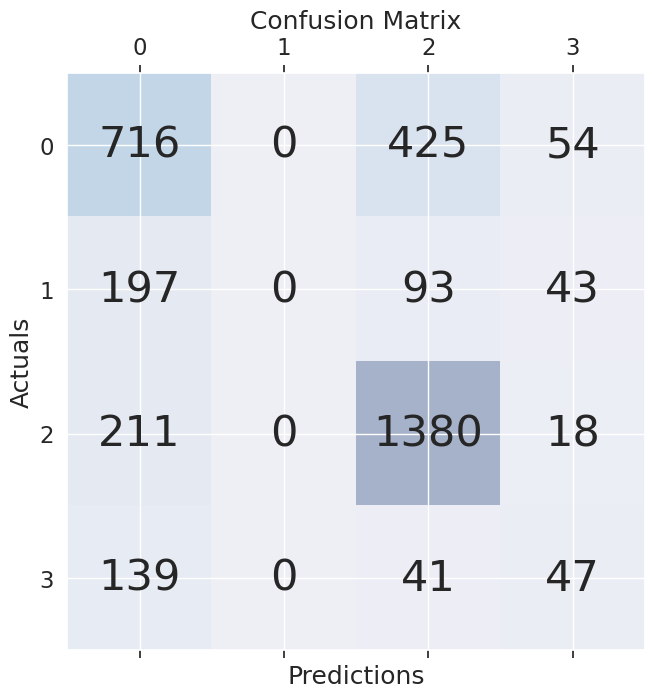



None


In [ ]:
training_stats= train(model, optimizer1, scheduler1, train_dataloader, validation_dataloader, epochs=15)

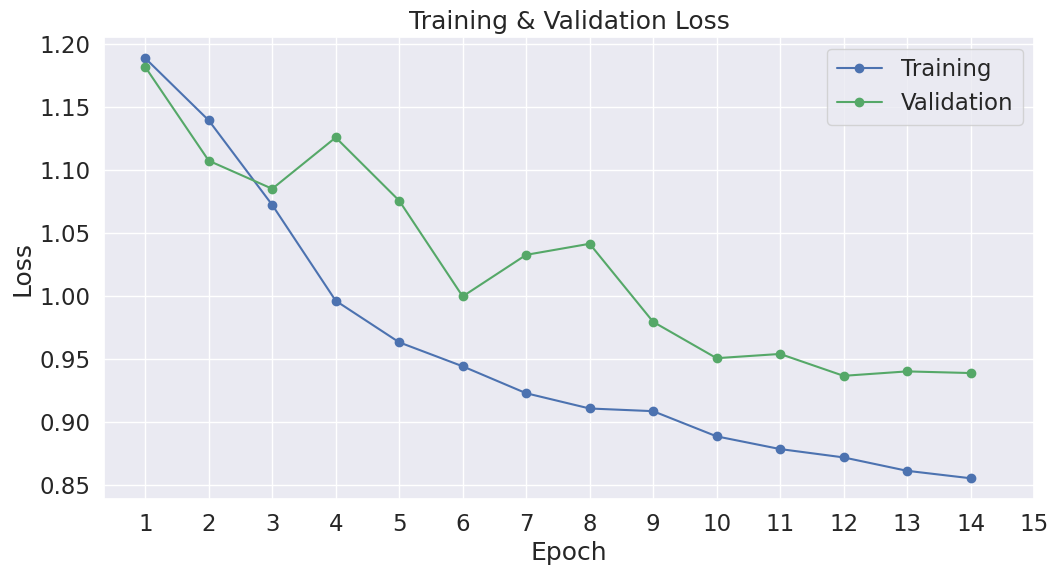

In [ ]:
stats(training_stats,15)

In [ ]:
# Load best model
path='saved_weights_bertimbau.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
predictions, true_labels= test(model, test_dataloader)

Predicting labels for 3,365 test sentences...
    DONE.


In [ ]:
predictions_concatenated = np.concatenate(predictions)
print(len(predictions_concatenated))
true_labels_concatenated = np.concatenate(true_labels)
print(len(true_labels_concatenated))

3365
3365


CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.56      0.59      0.57      1195
           1       0.00      0.00      0.00       333
           2       0.69      0.88      0.77      1609
           3       0.39      0.14      0.20       228

    accuracy                           0.64      3365
   macro avg       0.41      0.40      0.39      3365
weighted avg       0.56      0.64      0.59      3365



CONFUSION MATRIX


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


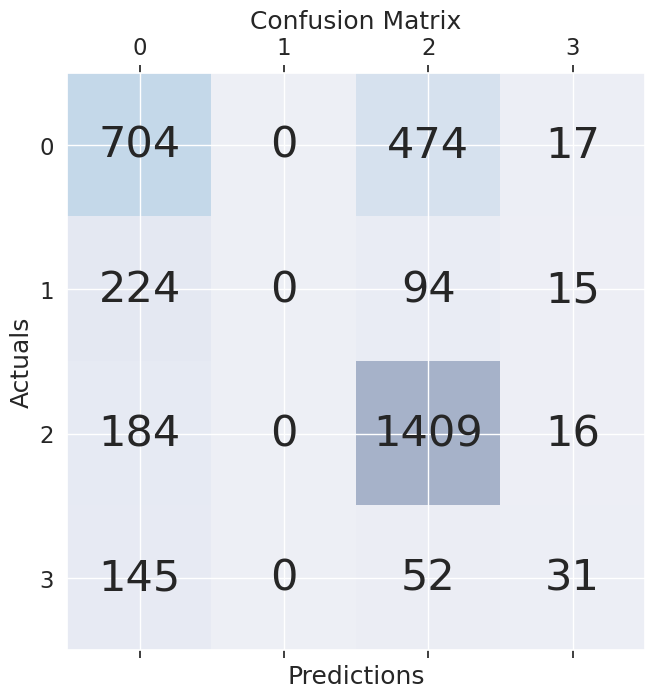

In [ ]:
get_metrics(predictions,true_labels)

# add 0.2 dropout to the best model

In [ ]:
from transformers import BertModel, BertForSequenceClassification, BertConfig

# Load the existing model configuration
config = BertConfig.from_pretrained(
    "neuralmind/bert-base-portuguese-cased",
    num_labels=4,
    output_attentions=False,
    output_hidden_states=False
)

# Adjust dropout rates as needed
config.hidden_dropout_prob = 0.2  # before 0.1
config.attention_probs_dropout_prob = 0.2  # before 0.1

# Create the modified BertForSequenceClassification model
model = BertForSequenceClassification(config)

model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.2, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
train_dataset,val_dataset,test_dataset=create_tensors(X_train,X_val,X_test,128,tokenizer)
train_dataloader, validation_dataloader, test_dataloader= create_dataloaders(train_dataset,val_dataset,test_dataset, batch_s=32)

15701
3364
3365


In [ ]:
optimizer1, scheduler1 = set_configs(model, train_dataloader, learning_rate=8.23828987673291e-06, epochs=15, weight_decay=0.07559054336016528)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



======== Epoch 1 / 15 ========
Training...
  Batch    50  of    491.    Elapsed: 0:00:11.
  Batch   100  of    491.    Elapsed: 0:00:22.
  Batch   150  of    491.    Elapsed: 0:00:33.
  Batch   200  of    491.    Elapsed: 0:00:44.
  Batch   250  of    491.    Elapsed: 0:00:54.
  Batch   300  of    491.    Elapsed: 0:01:05.
  Batch   350  of    491.    Elapsed: 0:01:17.
  Batch   400  of    491.    Elapsed: 0:01:28.
  Batch   450  of    491.    Elapsed: 0:01:39.

  Average training loss: 1.16
  Training epoch took: 0:01:48

Running Validation...
  Accuracy: 0.48
Saving model
  Validation Loss: 1.14
  Validation took: 0:00:13

======== Epoch 2 / 15 ========
Training...
  Batch    50  of    491.    Elapsed: 0:00:11.
  Batch   100  of    491.    Elapsed: 0:00:22.
  Batch   150  of    491.    Elapsed: 0:00:33.
  Batch   200  of    491.    Elapsed: 0:00:43.
  Batch   250  of    491.    Elapsed: 0:00:54.
  Batch   300  of    491.    Elapsed: 0:01:05.
  Batch   350  of    491.    Elapsed: 0:0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


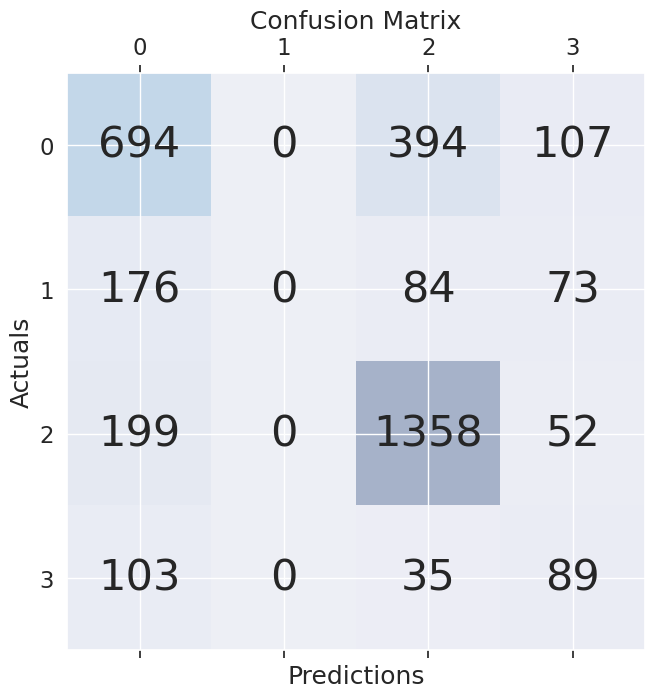



None


In [ ]:
training_stats= train(model, optimizer1, scheduler1, train_dataloader, validation_dataloader, epochs=15)

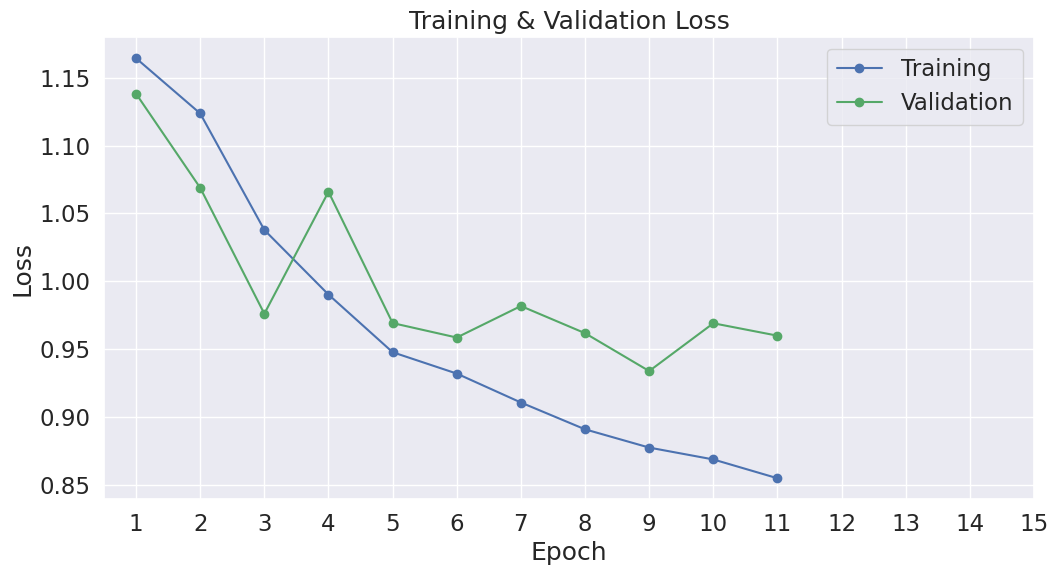

In [ ]:
stats(training_stats,15)

In [ ]:
# Load best model
path='saved_weights_bertimbau.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
predictions, true_labels= test(model, test_dataloader)
predictions_concatenated = np.concatenate(predictions)
true_labels_concatenated = np.concatenate(true_labels)

Predicting labels for 3,365 test sentences...
    DONE.


CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.54      0.60      0.57      1195
           1       0.00      0.00      0.00       333
           2       0.70      0.86      0.77      1609
           3       0.38      0.11      0.16       228

    accuracy                           0.63      3365
   macro avg       0.40      0.39      0.38      3365
weighted avg       0.55      0.63      0.58      3365



CONFUSION MATRIX


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


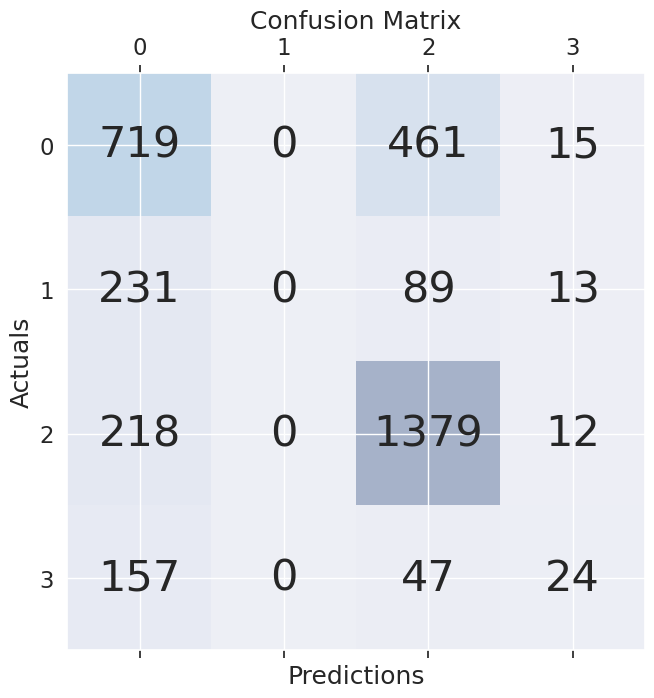

In [ ]:
get_metrics(predictions,true_labels)

**how to add dropout to the best model (other layers)**

1. **Input Embedding Layer:**
   This layer converts input tokens into continuous embeddings. Increasing dropout in this layer might be helpful when the input data is noisy or has a lot of variability. Higher dropout can help the model become more robust to different word representations, especially when dealing with diverse text sources or noisy text data.

2. **Self-Attention Layer:**
   The self-attention mechanism captures contextual relationships between words in a sentence. Increasing dropout in this layer could be beneficial when you have very long sentences or documents, as it may prevent the model from overfitting to specific local contexts and encourage it to capture more global context. This could potentially enhance the model's ability to handle longer documents.

3. **Feedforward Neural Network Layer:**
   The feedforward layer processes the outputs of the self-attention layer. Increasing dropout here might help regularize the model and prevent overfitting, especially if the feedforward layer is very wide (has many neurons) or the training data is limited. However, too much dropout could hinder the model's capacity to learn complex mappings, so a balance needs to be struck.

4. **Output Layer:**
   The final output layer of BERT produces the contextualized representations of input tokens. Increasing dropout here might be helpful if the model is fine-tuned on a specific downstream task and the task's training data is limited or noisy. However, excessive dropout could lead to underfitting on the task-specific data, so careful tuning is necessary.

from chatgpt

In [ ]:
# Modify the dropout rates
# model.bert.embeddings.dropout = nn.Dropout(0.2)

# for layer in model.bert.encoder.layer:
#     layer.attention.self.dropout = nn.Dropout(0.3)
#     layer.attention.output.dropout = nn.Dropout(0.3)
#     layer.intermediate.dropout = nn.Dropout(0.3)
#     layer.output.dropout = nn.Dropout(0.3)

# model.bert.pooler.dropout = nn.Dropout(0.3)
# model.dropout = nn.Dropout(0.3)

In [ ]:
import torch
import torch.nn as nn
from transformers import BertForSequenceClassification

# Load the existing model configuration
model = BertForSequenceClassification.from_pretrained(
    "neuralmind/bert-base-portuguese-cased",
    num_labels=4,
    output_attentions=False,
    output_hidden_states=False
)

# Modify the BERT model by adding dropout to specific layers
for layer in model.bert.encoder.layer:
    # Add dropout to attention layer
    layer.attention.self.dropout = nn.Dropout(p=0.2)  # You can adjust the dropout rate as needed

    # Add dropout to intermediate layer
    layer.intermediate.dense = nn.Sequential(
        nn.Linear(layer.intermediate.dense.in_features, layer.intermediate.dense.out_features),
        nn.ReLU(),
        nn.Dropout(p=0.2)  # You can adjust the dropout rate as needed
    )


model.to(device)

**optuna to find best dropout ??**

In [ ]:
import torch
import torch.nn as nn
from transformers import BertForSequenceClassification

# Load the pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

# Modify the dropout rates
model.bert.embeddings.dropout = nn.Dropout(0.2)

for layer in model.bert.encoder.layer:
    layer.attention.self.dropout = nn.Dropout(0.3)
    layer.attention.output.dropout = nn.Dropout(0.3)
    layer.intermediate.dropout = nn.Dropout(0.3)
    layer.output.dropout = nn.Dropout(0.3)

model.bert.pooler.dropout = nn.Dropout(0.3)
model.dropout = nn.Dropout(0.3)

In [ ]:
# Define the hyperparameter search space for dropout rates
    embedding_dropout = trial.suggest_float('embedding_dropout', 0.1, 0.5)
    attention_dropout = trial.suggest_float('attention_dropout', 0.1, 0.5)
    intermediate_dropout = trial.suggest_float('intermediate_dropout', 0.1, 0.5)
    output_dropout = trial.suggest_float('output_dropout', 0.1, 0.5)
    pooler_dropout = trial.suggest_float('pooler_dropout', 0.1, 0.5)
    final_dropout = trial.suggest_float('final_dropout', 0.1, 0.5)

    # Load the pre-trained BERT model
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

    # Modify the dropout rates based on trial suggestions
    model.bert.embeddings.dropout = nn.Dropout(embedding_dropout)

    for layer in model.bert.encoder.layer:
        layer.attention.self.dropout = nn.Dropout(attention_dropout)
        layer.attention.output.dropout = nn.Dropout(attention_dropout)
        layer.intermediate.dropout = nn.Dropout(intermediate_dropout)
        layer.output.dropout = nn.Dropout(output_dropout)

    model.bert.pooler.dropout = nn.Dropout(pooler_dropout)
    model.dropout = nn.Dropout(final_dropout)

# description + title

In [ ]:
feature_set = ['narrative_bert','title']
narrative_bert_title = data[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)

In [ ]:
# identify features and target
sentences = narrative_bert_title.values
labels = data.reason.values

In [ ]:
# tokenize the text feature
tokenized_feature_raw = tokenizer.batch_encode_plus(
                            # Sentences to encode
                            sentences.tolist(),
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True
                   )
token_sentence_length=[]
# collect tokenized sentence length
for i in range(len(tokenized_feature_raw['input_ids'])):
    token_sentence_length=token_sentence_length+[len(tokenized_feature_raw['input_ids'][i])]

print('max: ', max(token_sentence_length))
print('min: ', min(token_sentence_length))

data['complaint_length'] = token_sentence_length

max:  10565
min:  41


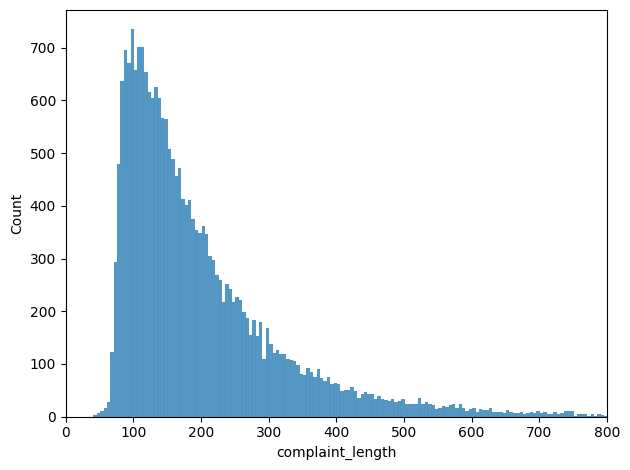

In [ ]:
ax=sns.histplot(x=data['complaint_length'],binwidth=5)
plt.xlim(0, 800)
plt.tight_layout()
plt.show()

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.3, stratify=labels, random_state=42)

# Split the remaining data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

In [ ]:
# https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb#scrollTo=mjJGEXShp7te
from transformers import BertForSequenceClassification
import torch.nn as nn

model = BertForSequenceClassification.from_pretrained(
    "neuralmind/bert-base-portuguese-cased",
    num_labels=4,
    output_attentions=False,
    output_hidden_states=False
)

# Tell PyTorch to run the model on the GPU
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
train_dataset,val_dataset,test_dataset=create_tensors(X_train,X_val,X_test,256,tokenizer)
train_dataloader, validation_dataloader, test_dataloader= create_dataloaders(train_dataset,val_dataset,test_dataset, batch_s=32)

15701
3364
3365


In [ ]:
optimizer1, scheduler1 = set_configs(model, train_dataloader, learning_rate=8.23828987673291e-06, epochs=15, weight_decay=0.07559054336016528)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



======== Epoch 1 / 15 ========
Training...
  Batch    50  of    491.    Elapsed: 0:00:24.
  Batch   100  of    491.    Elapsed: 0:00:48.
  Batch   150  of    491.    Elapsed: 0:01:13.
  Batch   200  of    491.    Elapsed: 0:01:37.
  Batch   250  of    491.    Elapsed: 0:02:01.
  Batch   300  of    491.    Elapsed: 0:02:25.
  Batch   350  of    491.    Elapsed: 0:02:49.
  Batch   400  of    491.    Elapsed: 0:03:13.
  Batch   450  of    491.    Elapsed: 0:03:36.

  Average training loss: 1.17
  Training epoch took: 0:03:55

Running Validation...
  Accuracy: 0.62
Saving model
  Validation Loss: 1.00
  Validation took: 0:00:17

======== Epoch 2 / 15 ========
Training...
  Batch    50  of    491.    Elapsed: 0:00:24.
  Batch   100  of    491.    Elapsed: 0:00:47.
  Batch   150  of    491.    Elapsed: 0:01:11.
  Batch   200  of    491.    Elapsed: 0:01:34.
  Batch   250  of    491.    Elapsed: 0:01:58.
  Batch   300  of    491.    Elapsed: 0:02:22.
  Batch   350  of    491.    Elapsed: 0:0

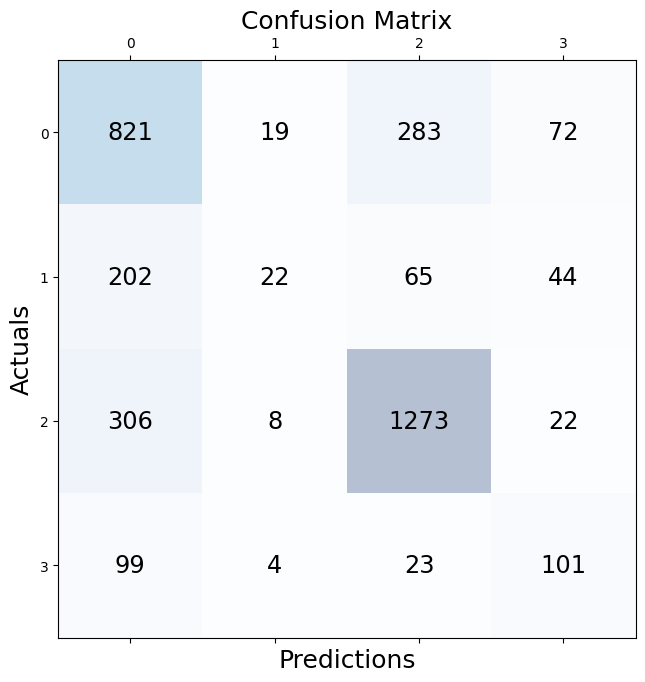



None


In [ ]:
training_stats= train(model, optimizer1, scheduler1, train_dataloader, validation_dataloader, epochs=15)

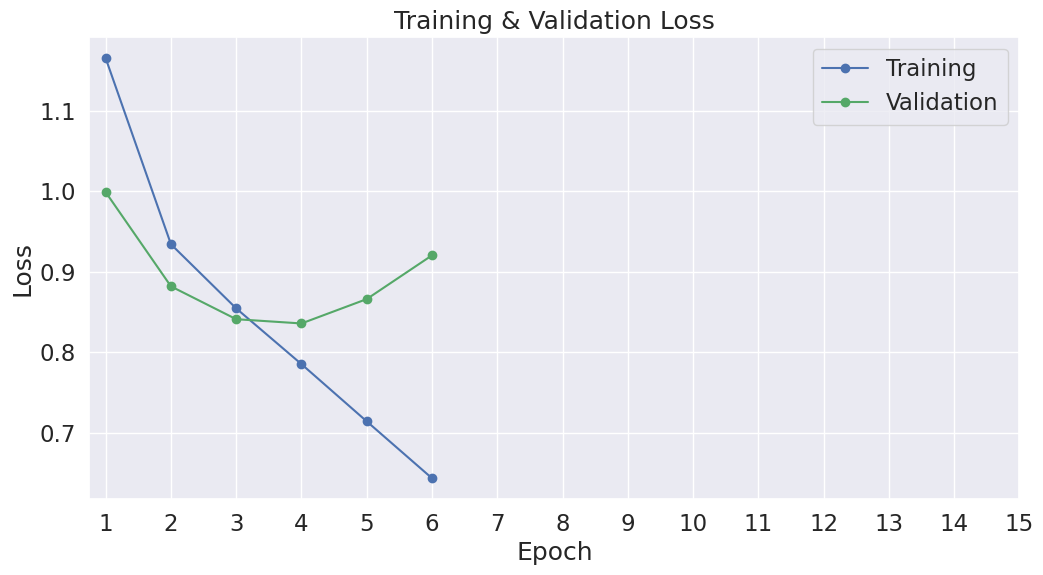

In [ ]:
stats(training_stats,15)

In [ ]:
# Load best model
path='saved_weights_bertimbau.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
predictions, true_labels= test(model, test_dataloader)

Predicting labels for 3,365 test sentences...
    DONE.


In [ ]:
predictions_concatenated = np.concatenate(predictions)
print(len(predictions_concatenated))
true_labels_concatenated = np.concatenate(true_labels)
print(len(true_labels_concatenated))

3365
3365


CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.58      0.66      0.62      1195
           1       1.00      0.02      0.04       333
           2       0.74      0.87      0.80      1609
           3       0.47      0.26      0.33       228

    accuracy                           0.67      3365
   macro avg       0.70      0.45      0.45      3365
weighted avg       0.69      0.67      0.63      3365



CONFUSION MATRIX


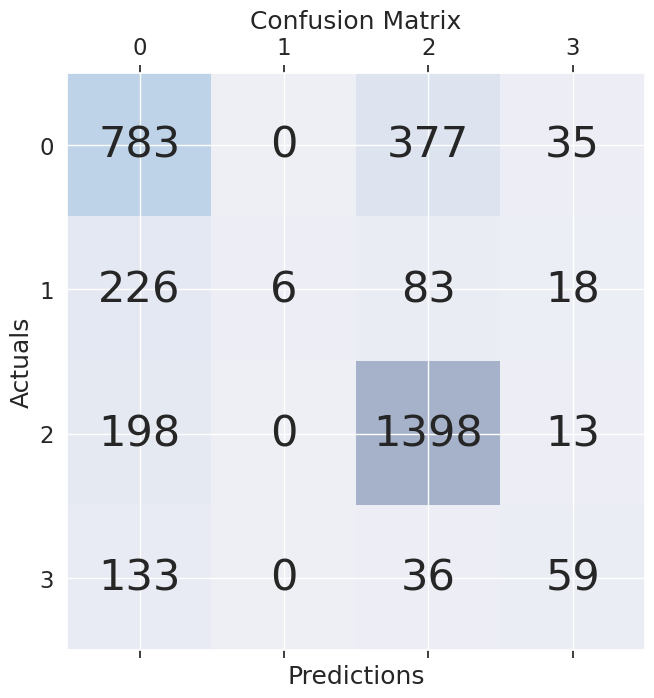

In [ ]:
get_metrics(predictions,true_labels)

# description + title + keywords

In [ ]:
feature_set = ['narrative_bert','title','embeddings_keywords']
narrative_bert_title = data[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)

In [ ]:
# identify features and target
sentences = narrative_bert_title.values
labels = data.reason.values

In [ ]:
# tokenize the text feature
tokenized_feature_raw = tokenizer.batch_encode_plus(
                            # Sentences to encode
                            sentences.tolist(),
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True
                   )
token_sentence_length=[]
# collect tokenized sentence length
for i in range(len(tokenized_feature_raw['input_ids'])):
    token_sentence_length=token_sentence_length+[len(tokenized_feature_raw['input_ids'][i])]

print('max: ', max(token_sentence_length))
print('min: ', min(token_sentence_length))

data['complaint_length'] = token_sentence_length

max:  10595
min:  57


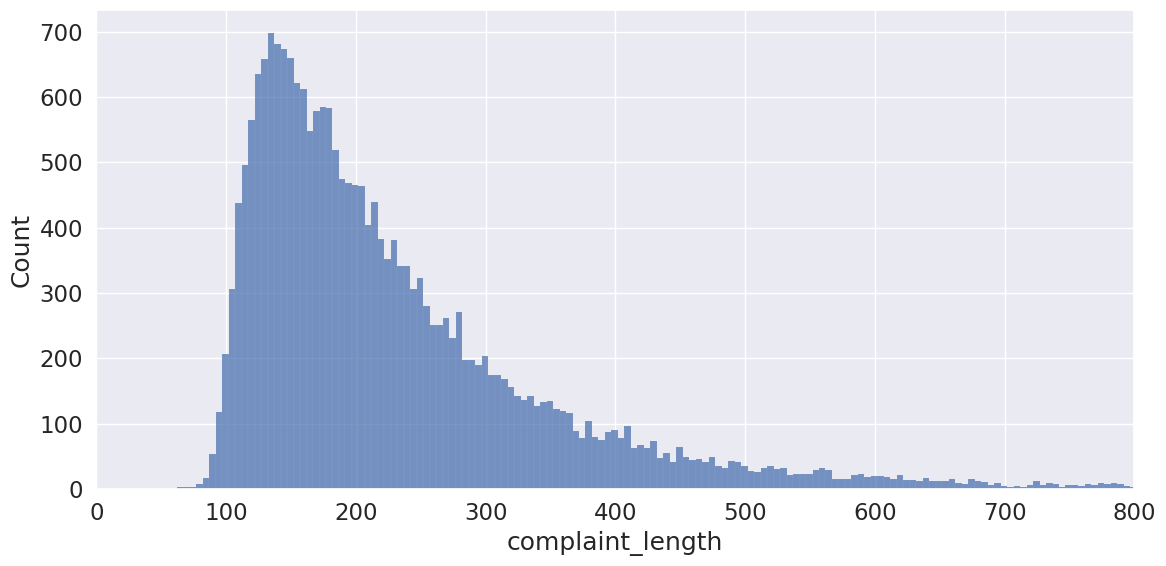

In [ ]:
ax=sns.histplot(x=data['complaint_length'],binwidth=5)
plt.xlim(0, 800)
plt.tight_layout()
plt.show()

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.3, stratify=labels, random_state=42)

# Split the remaining data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

In [ ]:
# https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb#scrollTo=mjJGEXShp7te
from transformers import BertForSequenceClassification
import torch.nn as nn

model = BertForSequenceClassification.from_pretrained(
    "neuralmind/bert-base-portuguese-cased",
    num_labels=4,
    output_attentions=False,
    output_hidden_states=False
)

# Tell PyTorch to run the model on the GPU
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
train_dataset,val_dataset,test_dataset=create_tensors(X_train,X_val,X_test,256,tokenizer)
train_dataloader, validation_dataloader, test_dataloader= create_dataloaders(train_dataset,val_dataset,test_dataset, batch_s=32)

15701
3364
3365


In [ ]:
optimizer1, scheduler1 = set_configs(model, train_dataloader, learning_rate=8.23828987673291e-06, epochs=15, weight_decay=0.07559054336016528)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



======== Epoch 1 / 15 ========
Training...
  Batch    50  of    491.    Elapsed: 0:00:24.
  Batch   100  of    491.    Elapsed: 0:00:48.
  Batch   150  of    491.    Elapsed: 0:01:12.
  Batch   200  of    491.    Elapsed: 0:01:36.
  Batch   250  of    491.    Elapsed: 0:01:59.
  Batch   300  of    491.    Elapsed: 0:02:23.
  Batch   350  of    491.    Elapsed: 0:02:47.
  Batch   400  of    491.    Elapsed: 0:03:11.
  Batch   450  of    491.    Elapsed: 0:03:35.

  Average training loss: 1.16
  Training epoch took: 0:03:54

Running Validation...
  Accuracy: 0.61
Saving model
  Validation Loss: 1.02
  Validation took: 0:00:17

======== Epoch 2 / 15 ========
Training...
  Batch    50  of    491.    Elapsed: 0:00:24.
  Batch   100  of    491.    Elapsed: 0:00:48.
  Batch   150  of    491.    Elapsed: 0:01:12.
  Batch   200  of    491.    Elapsed: 0:01:36.
  Batch   250  of    491.    Elapsed: 0:02:00.
  Batch   300  of    491.    Elapsed: 0:02:24.
  Batch   350  of    491.    Elapsed: 0:0

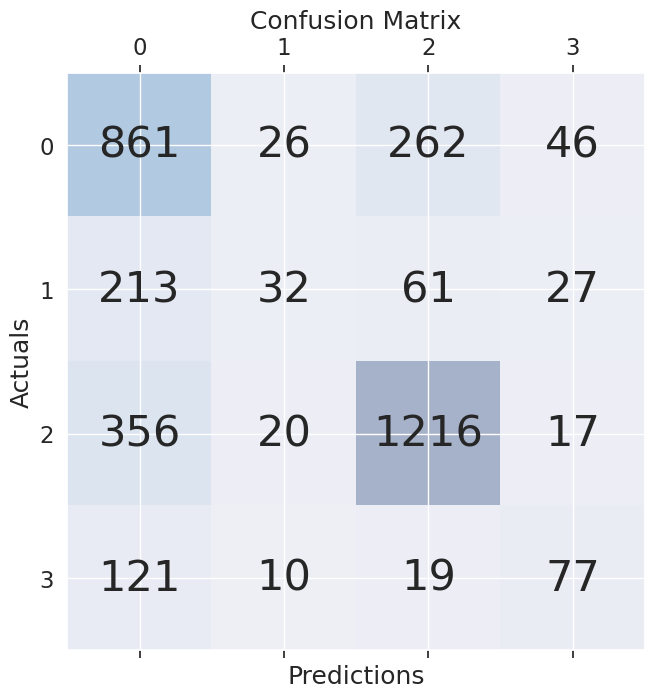



None


In [ ]:
training_stats= train(model, optimizer1, scheduler1, train_dataloader, validation_dataloader, epochs=15)

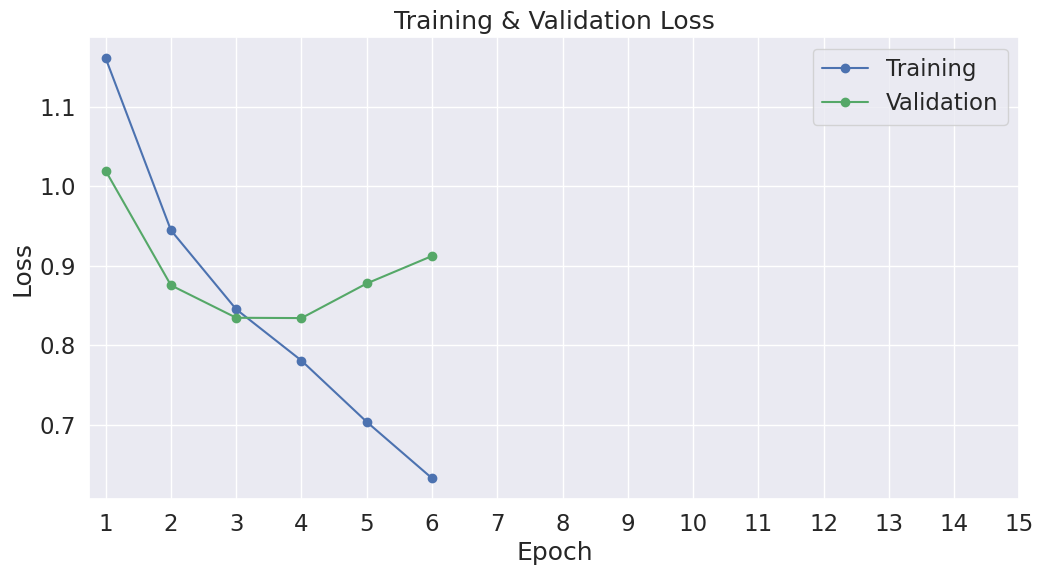

In [ ]:
stats(training_stats,15)

In [ ]:
# Load best model
path='saved_weights_bertimbau.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
predictions, true_labels= test(model, test_dataloader)

Predicting labels for 3,365 test sentences...
    DONE.


In [ ]:
predictions_concatenated = np.concatenate(predictions)
print(len(predictions_concatenated))
true_labels_concatenated = np.concatenate(true_labels)
print(len(true_labels_concatenated))

3365
3365


CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.57      0.69      0.63      1195
           1       0.38      0.02      0.03       333
           2       0.76      0.83      0.79      1609
           3       0.49      0.30      0.37       228

    accuracy                           0.67      3365
   macro avg       0.55      0.46      0.45      3365
weighted avg       0.64      0.67      0.63      3365



CONFUSION MATRIX


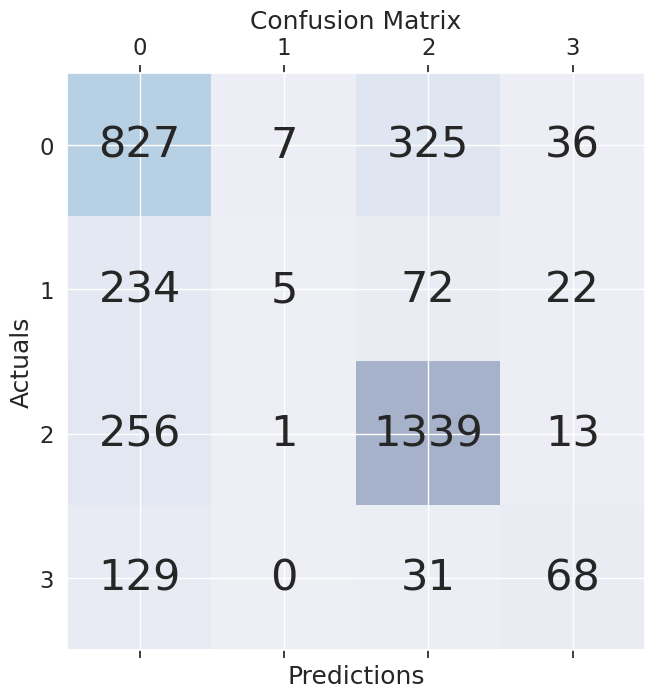

In [ ]:
get_metrics(predictions,true_labels)

# description + title + events

In [ ]:
feature_set = ['narrative_bert','title','events_clean']
narrative_bert_title = data[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)

In [ ]:
# identify features and target
sentences = narrative_bert_title.values
labels = data.reason.values

In [ ]:
# tokenize the text feature
tokenized_feature_raw = tokenizer.batch_encode_plus(
                            # Sentences to encode
                            sentences.tolist(),
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True
                   )
token_sentence_length=[]
# collect tokenized sentence length
for i in range(len(tokenized_feature_raw['input_ids'])):
    token_sentence_length=token_sentence_length+[len(tokenized_feature_raw['input_ids'][i])]

print('max: ', max(token_sentence_length))
print('min: ', min(token_sentence_length))

data['complaint_length'] = token_sentence_length

max:  12003
min:  45


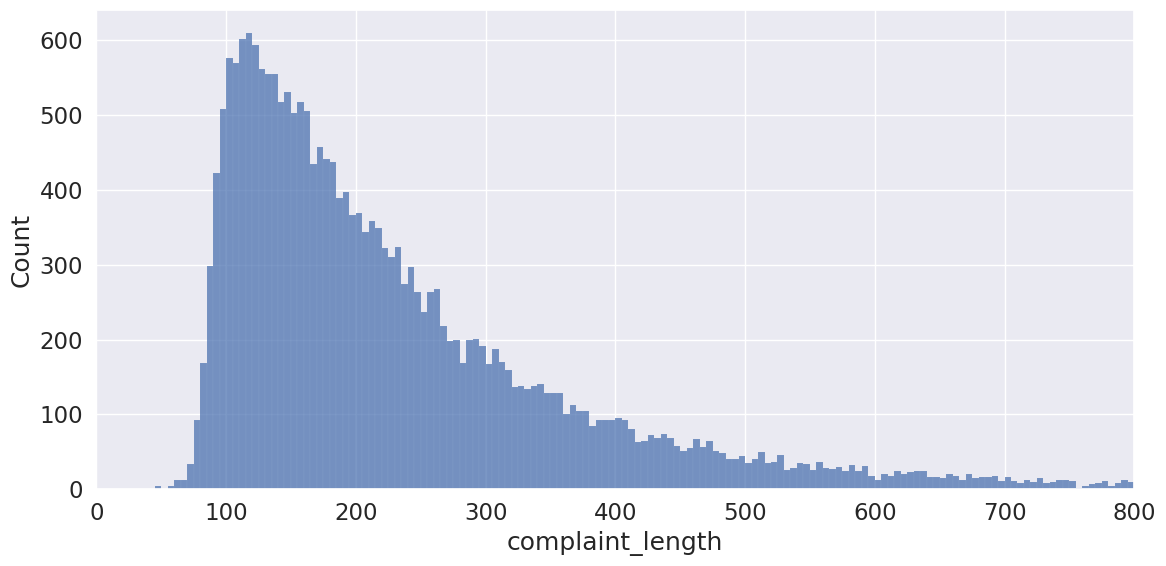

In [ ]:
ax=sns.histplot(x=data['complaint_length'],binwidth=5)
plt.xlim(0, 800)
plt.tight_layout()
plt.show()

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.3, stratify=labels, random_state=42)

# Split the remaining data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

In [ ]:
# https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb#scrollTo=mjJGEXShp7te
from transformers import BertForSequenceClassification
import torch.nn as nn

model = BertForSequenceClassification.from_pretrained(
    "neuralmind/bert-base-portuguese-cased",
    num_labels=4,
    output_attentions=False,
    output_hidden_states=False
)

# Tell PyTorch to run the model on the GPU
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
train_dataset,val_dataset,test_dataset=create_tensors(X_train,X_val,X_test,256,tokenizer)
train_dataloader, validation_dataloader, test_dataloader= create_dataloaders(train_dataset,val_dataset,test_dataset, batch_s=32)

15701
3364
3365


In [ ]:
optimizer1, scheduler1 = set_configs(model, train_dataloader, learning_rate=8.23828987673291e-06, epochs=15, weight_decay=0.07559054336016528)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



======== Epoch 1 / 15 ========
Training...
  Batch    50  of    491.    Elapsed: 0:00:24.
  Batch   100  of    491.    Elapsed: 0:00:48.
  Batch   150  of    491.    Elapsed: 0:01:12.
  Batch   200  of    491.    Elapsed: 0:01:35.
  Batch   250  of    491.    Elapsed: 0:02:00.
  Batch   300  of    491.    Elapsed: 0:02:23.
  Batch   350  of    491.    Elapsed: 0:02:47.
  Batch   400  of    491.    Elapsed: 0:03:11.
  Batch   450  of    491.    Elapsed: 0:03:35.

  Average training loss: 1.19
  Training epoch took: 0:03:55

Running Validation...
  Accuracy: 0.59
Saving model
  Validation Loss: 1.04
  Validation took: 0:00:17

======== Epoch 2 / 15 ========
Training...
  Batch    50  of    491.    Elapsed: 0:00:24.
  Batch   100  of    491.    Elapsed: 0:00:48.
  Batch   150  of    491.    Elapsed: 0:01:12.
  Batch   200  of    491.    Elapsed: 0:01:35.
  Batch   250  of    491.    Elapsed: 0:02:00.
  Batch   300  of    491.    Elapsed: 0:02:24.
  Batch   350  of    491.    Elapsed: 0:0

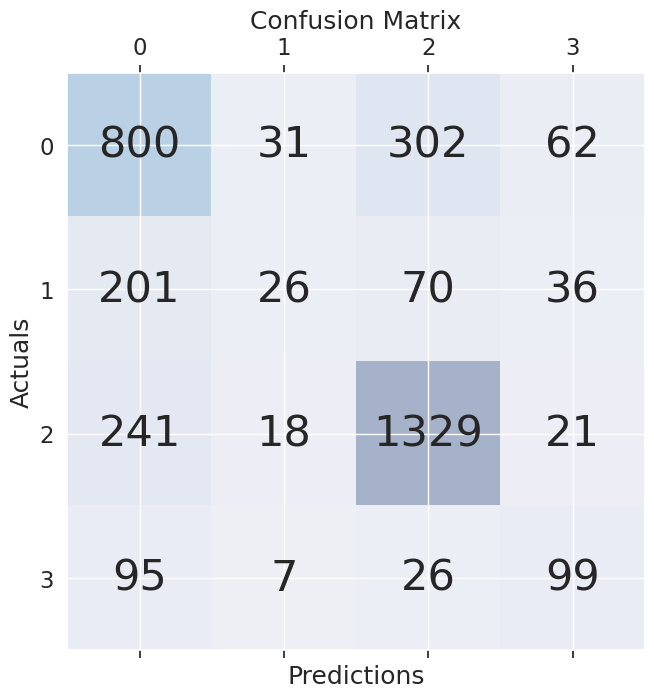



None


In [ ]:
training_stats= train(model, optimizer1, scheduler1, train_dataloader, validation_dataloader, epochs=15)

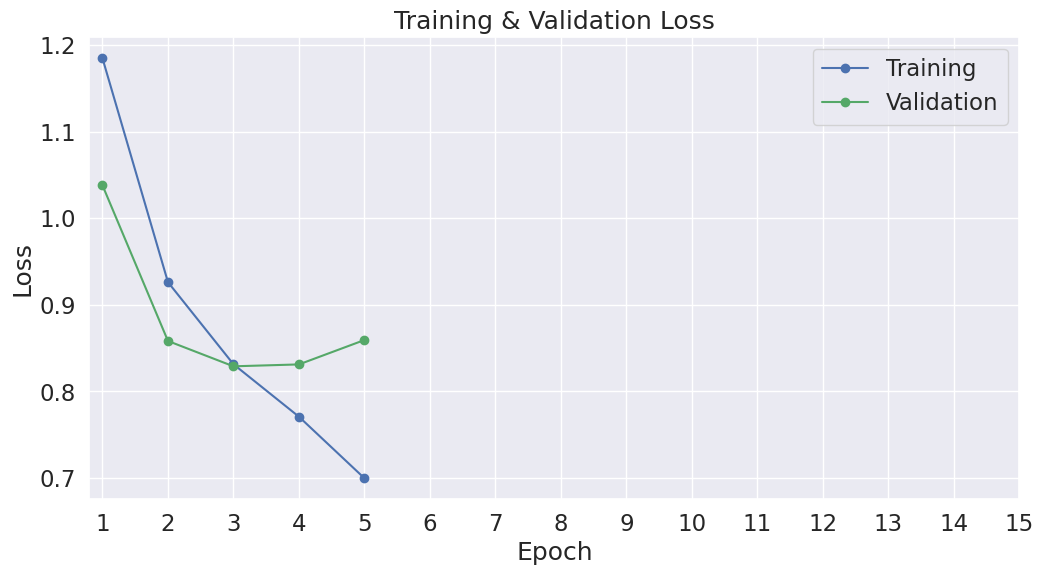

In [ ]:
stats(training_stats,15)

In [ ]:
# Load best model
path='saved_weights_bertimbau.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
predictions, true_labels= test(model, test_dataloader)

Predicting labels for 3,365 test sentences...
    DONE.


In [ ]:
predictions_concatenated = np.concatenate(predictions)
print(len(predictions_concatenated))
true_labels_concatenated = np.concatenate(true_labels)
print(len(true_labels_concatenated))

3365
3365


CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.59      0.64      0.61      1195
           1       0.33      0.00      0.01       333
           2       0.73      0.88      0.79      1609
           3       0.50      0.29      0.37       228

    accuracy                           0.66      3365
   macro avg       0.54      0.45      0.44      3365
weighted avg       0.62      0.66      0.62      3365



CONFUSION MATRIX


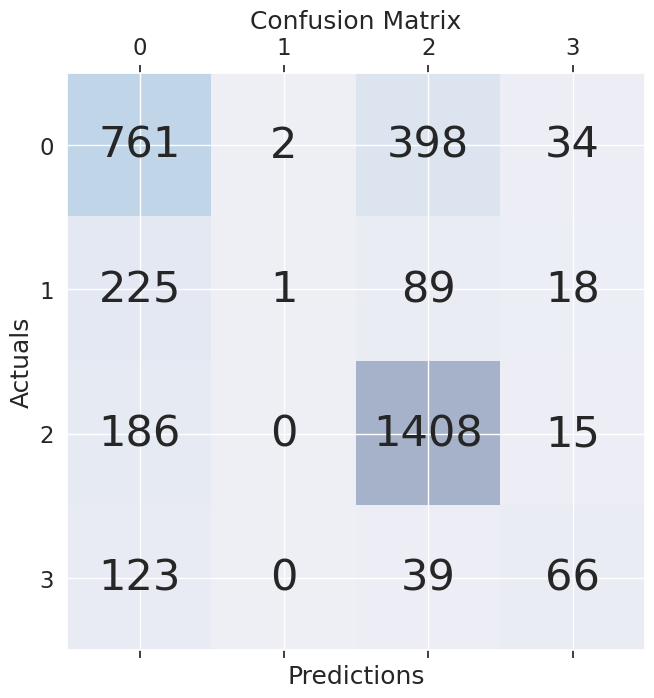

In [ ]:
get_metrics(predictions,true_labels)

# description + title + entities

In [ ]:
data.columns

Index(['date', 'title', 'reason', 'description', 'zone', 'narrative_tfidf',
       'narrative_embeddings', 'narrative_bert', 'narrative_tfidf_title',
       'narrative_bert_title', 'narrative_embeddings_title', 'tfidf_title',
       'title_tfidf_nolemma', 'events', 'keywords', 'embeddings_title',
       'tfidf_keywords', 'embeddings_keywords', 'events_clean',
       'results_final', 'events_tfidf', 'events_embeddings', 'orgs', 'locs',
       'entities', 'complaint_length'],
      dtype='object')

In [ ]:
feature_set = ['narrative_bert','title','entities']
narrative_bert_title = data[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)

In [ ]:
# identify features and target
sentences = narrative_bert_title.values
labels = data.reason.values

In [ ]:
# tokenize the text feature
tokenized_feature_raw = tokenizer.batch_encode_plus(
                            # Sentences to encode
                            sentences.tolist(),
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True
                   )
token_sentence_length=[]
# collect tokenized sentence length
for i in range(len(tokenized_feature_raw['input_ids'])):
    token_sentence_length=token_sentence_length+[len(tokenized_feature_raw['input_ids'][i])]

print('max: ', max(token_sentence_length))
print('min: ', min(token_sentence_length))

data['complaint_length'] = token_sentence_length

max:  10565
min:  41


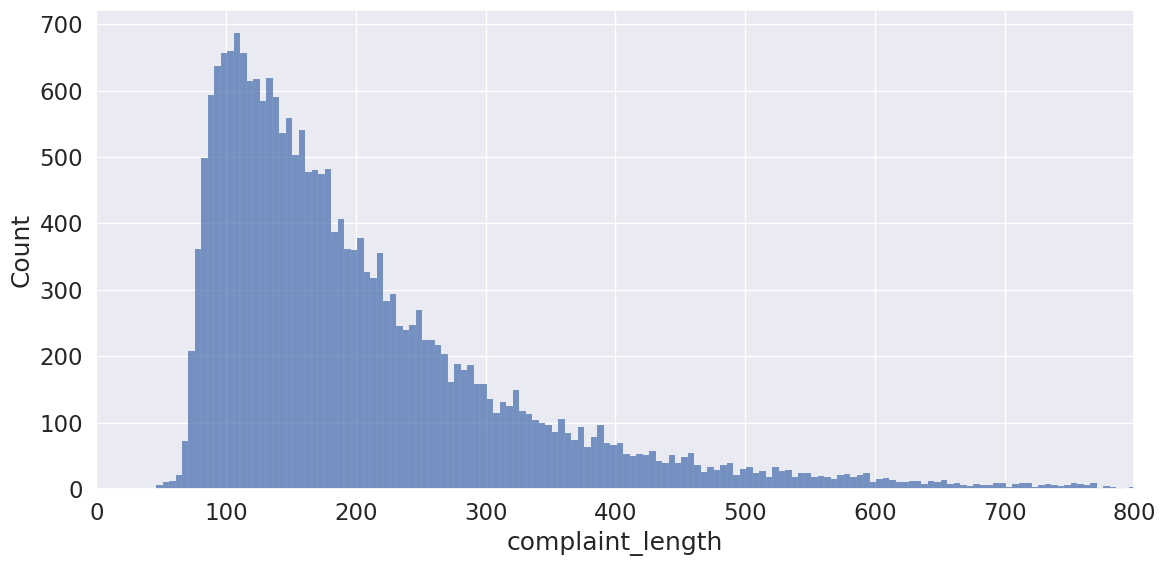

In [ ]:
ax=sns.histplot(x=data['complaint_length'],binwidth=5)
plt.xlim(0, 800)
plt.tight_layout()
plt.show()

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.3, stratify=labels, random_state=42)

# Split the remaining data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

In [ ]:
# https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb#scrollTo=mjJGEXShp7te
from transformers import BertForSequenceClassification
import torch.nn as nn

model = BertForSequenceClassification.from_pretrained(
    "neuralmind/bert-base-portuguese-cased",
    num_labels=4,
    output_attentions=False,
    output_hidden_states=False
)

# Tell PyTorch to run the model on the GPU
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
train_dataset,val_dataset,test_dataset=create_tensors(X_train,X_val,X_test,256,tokenizer)
train_dataloader, validation_dataloader, test_dataloader= create_dataloaders(train_dataset,val_dataset,test_dataset, batch_s=32)

15701
3364
3365


In [ ]:
optimizer1, scheduler1 = set_configs(model, train_dataloader, learning_rate=8.23828987673291e-06, epochs=15, weight_decay=0.07559054336016528)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



======== Epoch 1 / 15 ========
Training...
  Batch    50  of    491.    Elapsed: 0:00:24.
  Batch   100  of    491.    Elapsed: 0:00:48.
  Batch   150  of    491.    Elapsed: 0:01:12.
  Batch   200  of    491.    Elapsed: 0:01:36.
  Batch   250  of    491.    Elapsed: 0:02:00.
  Batch   300  of    491.    Elapsed: 0:02:24.
  Batch   350  of    491.    Elapsed: 0:02:48.
  Batch   400  of    491.    Elapsed: 0:03:12.
  Batch   450  of    491.    Elapsed: 0:03:36.

  Average training loss: 1.17
  Training epoch took: 0:03:56

Running Validation...
  Accuracy: 0.62
Saving model
  Validation Loss: 0.99
  Validation took: 0:00:17

======== Epoch 2 / 15 ========
Training...
  Batch    50  of    491.    Elapsed: 0:00:24.
  Batch   100  of    491.    Elapsed: 0:00:48.
  Batch   150  of    491.    Elapsed: 0:01:12.
  Batch   200  of    491.    Elapsed: 0:01:36.
  Batch   250  of    491.    Elapsed: 0:02:00.
  Batch   300  of    491.    Elapsed: 0:02:24.
  Batch   350  of    491.    Elapsed: 0:0

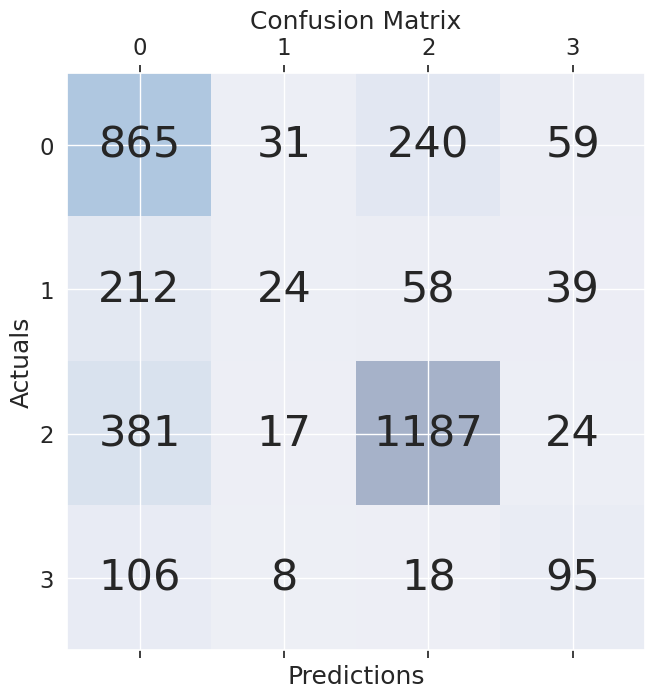



None


In [ ]:
training_stats= train(model, optimizer1, scheduler1, train_dataloader, validation_dataloader, epochs=15)

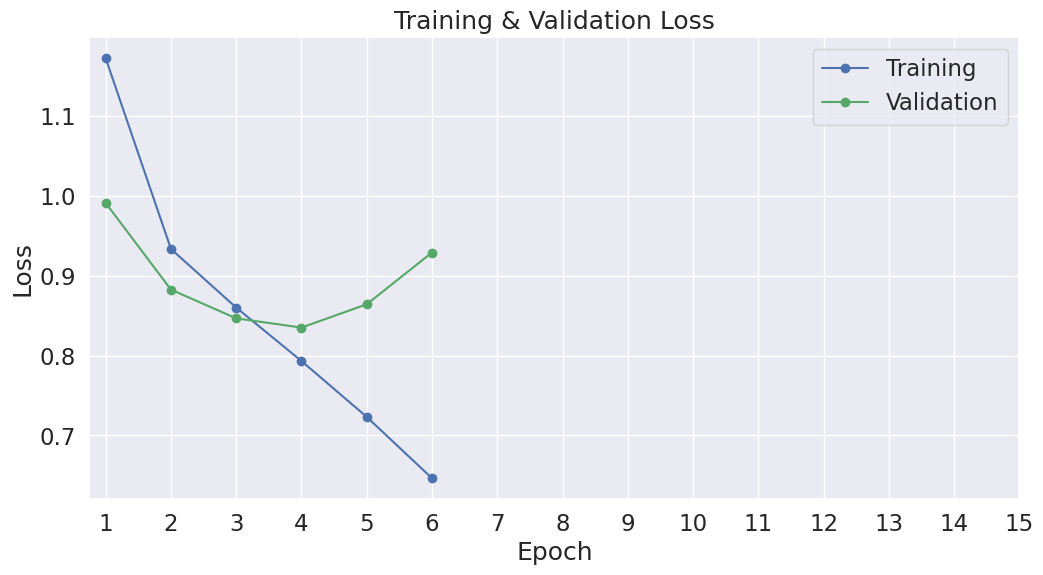

In [ ]:
stats(training_stats,15)

In [ ]:
# Load best model
path='saved_weights_bertimbau.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
predictions, true_labels= test(model, test_dataloader)

Predicting labels for 3,365 test sentences...
    DONE.


In [ ]:
predictions_concatenated = np.concatenate(predictions)
print(len(predictions_concatenated))
true_labels_concatenated = np.concatenate(true_labels)
print(len(true_labels_concatenated))

3365
3365


CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.58      0.66      0.62      1195
           1       0.75      0.01      0.02       333
           2       0.74      0.86      0.79      1609
           3       0.51      0.26      0.35       228

    accuracy                           0.67      3365
   macro avg       0.64      0.45      0.44      3365
weighted avg       0.67      0.67      0.62      3365



CONFUSION MATRIX


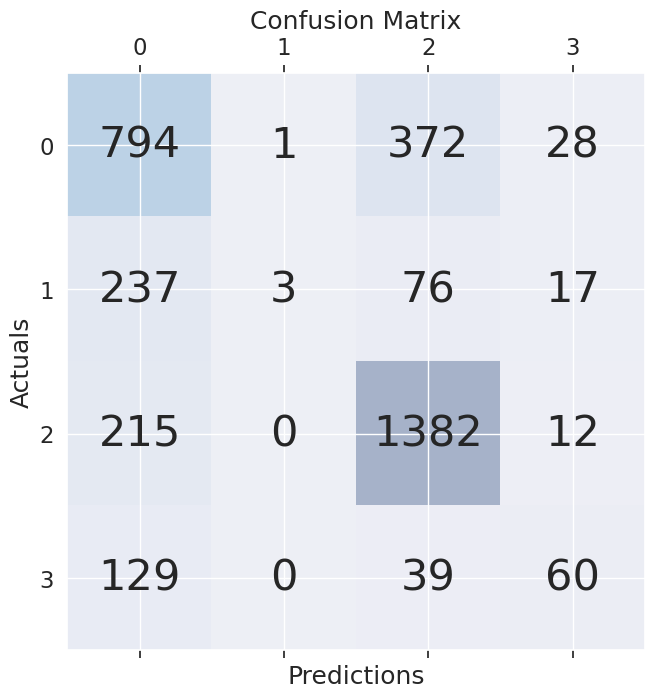

In [ ]:
get_metrics(predictions,true_labels)

# description + title + keywords + events

In [ ]:
feature_set = ['narrative_bert','title', 'embeddings_keywords','events_clean']
narrative_bert_title = data[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)

In [ ]:
# identify features and target
sentences = narrative_bert_title.values
labels = data.reason.values

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.3, stratify=labels, random_state=42)

# Split the remaining data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

In [ ]:
# tokenize the text feature
tokenized_feature_raw = tokenizer.batch_encode_plus(
                            # Sentences to encode
                            sentences.tolist(),
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True
                   )
token_sentence_length=[]
# collect tokenized sentence length
for i in range(len(tokenized_feature_raw['input_ids'])):
    token_sentence_length=token_sentence_length+[len(tokenized_feature_raw['input_ids'][i])]

print('max: ', max(token_sentence_length))
print('min: ', min(token_sentence_length))

data['complaint_length'] = token_sentence_length

max:  12033
min:  61


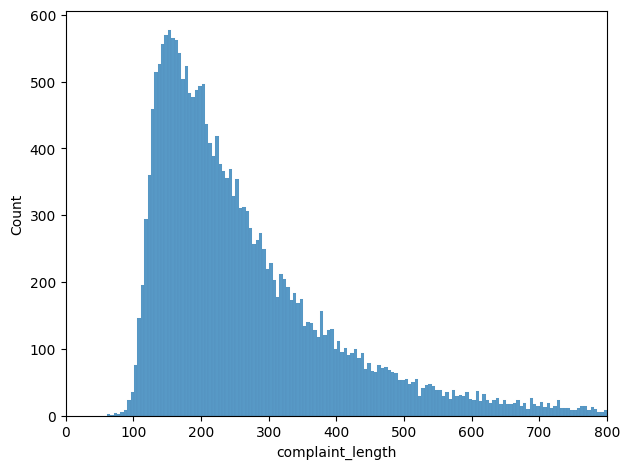

In [ ]:
ax=sns.histplot(x=data['complaint_length'],binwidth=5)
plt.xlim(0, 800)
plt.tight_layout()
plt.show()

In [ ]:
# https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb#scrollTo=mjJGEXShp7te
from transformers import BertForSequenceClassification
import torch.nn as nn

model = BertForSequenceClassification.from_pretrained(
    "neuralmind/bert-base-portuguese-cased",
    num_labels=4,
    output_attentions=False,
    output_hidden_states=False
)

# Tell PyTorch to run the model on the GPU
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
train_dataset,val_dataset,test_dataset=create_tensors(X_train,X_val,X_test,300,tokenizer)
train_dataloader, validation_dataloader, test_dataloader= create_dataloaders(train_dataset,val_dataset,test_dataset, batch_s=32)

15701
3364
3365


In [ ]:
optimizer1, scheduler1 = set_configs(model, train_dataloader, learning_rate=8.23828987673291e-06, epochs=15, weight_decay=0.07559054336016528)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



======== Epoch 1 / 15 ========
Training...
  Batch    50  of    491.    Elapsed: 0:00:32.
  Batch   100  of    491.    Elapsed: 0:00:59.
  Batch   150  of    491.    Elapsed: 0:01:27.
  Batch   200  of    491.    Elapsed: 0:01:55.
  Batch   250  of    491.    Elapsed: 0:02:23.
  Batch   300  of    491.    Elapsed: 0:02:51.
  Batch   350  of    491.    Elapsed: 0:03:18.
  Batch   400  of    491.    Elapsed: 0:03:46.
  Batch   450  of    491.    Elapsed: 0:04:14.

  Average training loss: 1.20
  Training epoch took: 0:04:36

Running Validation...
  Accuracy: 0.62
Saving model
  Validation Loss: 0.98
  Validation took: 0:00:19

======== Epoch 2 / 15 ========
Training...
  Batch    50  of    491.    Elapsed: 0:00:28.
  Batch   100  of    491.    Elapsed: 0:00:55.
  Batch   150  of    491.    Elapsed: 0:01:23.
  Batch   200  of    491.    Elapsed: 0:01:51.
  Batch   250  of    491.    Elapsed: 0:02:19.
  Batch   300  of    491.    Elapsed: 0:02:46.
  Batch   350  of    491.    Elapsed: 0:0

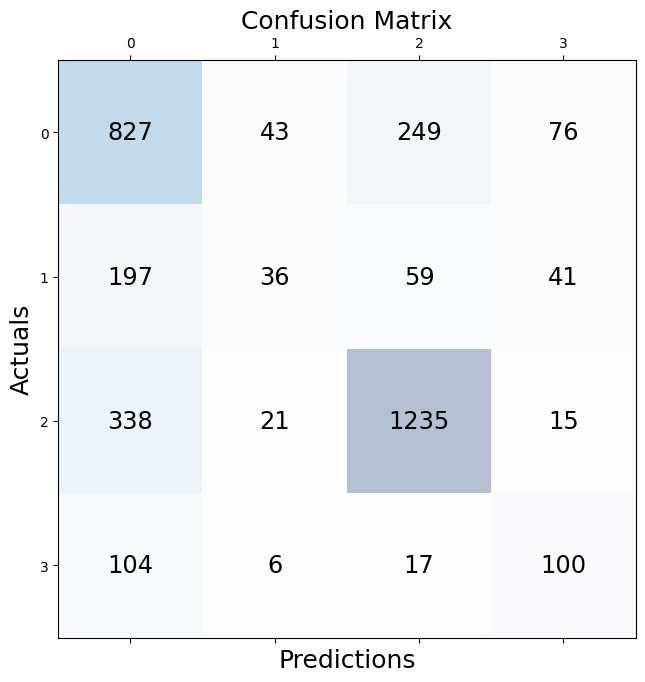



None


In [ ]:
training_stats= train(model, optimizer1, scheduler1, train_dataloader, validation_dataloader, epochs=15)

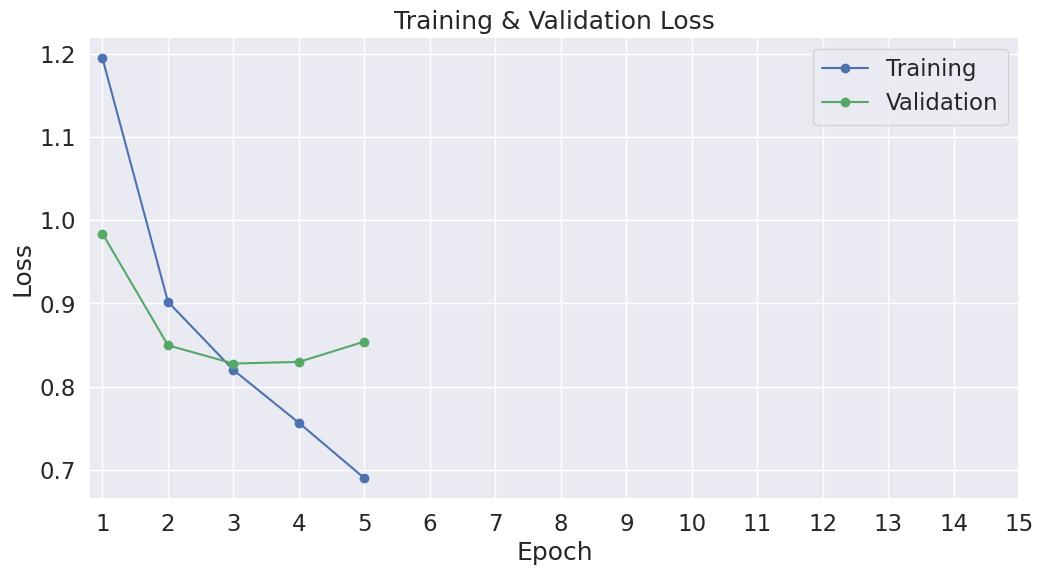

In [ ]:
stats(training_stats,15)

In [ ]:
# Load best model
path='saved_weights_bertimbau.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
predictions, true_labels= test(model, test_dataloader)

Predicting labels for 3,365 test sentences...
    DONE.


In [ ]:
predictions_concatenated = np.concatenate(predictions)
print(len(predictions_concatenated))
true_labels_concatenated = np.concatenate(true_labels)
print(len(true_labels_concatenated))

3365
3365


CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.58      0.63      0.61      1195
           1       0.27      0.01      0.02       333
           2       0.72      0.88      0.79      1609
           3       0.49      0.19      0.27       228

    accuracy                           0.66      3365
   macro avg       0.52      0.43      0.42      3365
weighted avg       0.61      0.66      0.61      3365



CONFUSION MATRIX


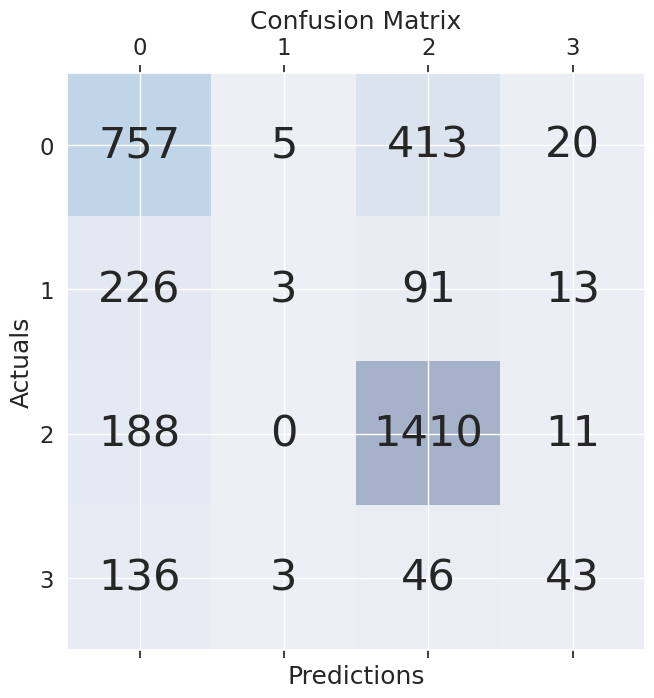

In [ ]:
get_metrics(predictions,true_labels)

# description + title + keywords + entities


In [ ]:
data.entities

0                          CTT, Aboboda, Israel
1                                           NaN
2                        Roissy, França, ROISSY
3        Correio, El Corte Inglés, Lisboa Verde
4                                           NaN
                          ...                  
22425                CTT, Reino Unido, Portugal
22426                                       NaN
22427                                AliExpress
22428                                    Lisboa
22429                                       NaN
Name: entities, Length: 22430, dtype: object

In [ ]:
feature_set=['narrative_bert', 'title', 'embeddings_keywords', 'entities']
all = data[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)

In [ ]:
# identify features and target
sentences = all.values
labels = data.reason.values

In [ ]:
# tokenize the text feature
tokenized_feature_raw = tokenizer.batch_encode_plus(
                            # Sentences to encode
                            sentences.tolist(),
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True
                   )
token_sentence_length=[]
# collect tokenized sentence length
for i in range(len(tokenized_feature_raw['input_ids'])):
    token_sentence_length=token_sentence_length+[len(tokenized_feature_raw['input_ids'][i])]

print('max: ', max(token_sentence_length))
print('min: ', min(token_sentence_length))

data['complaint_length'] = token_sentence_length

max:  10595
min:  57


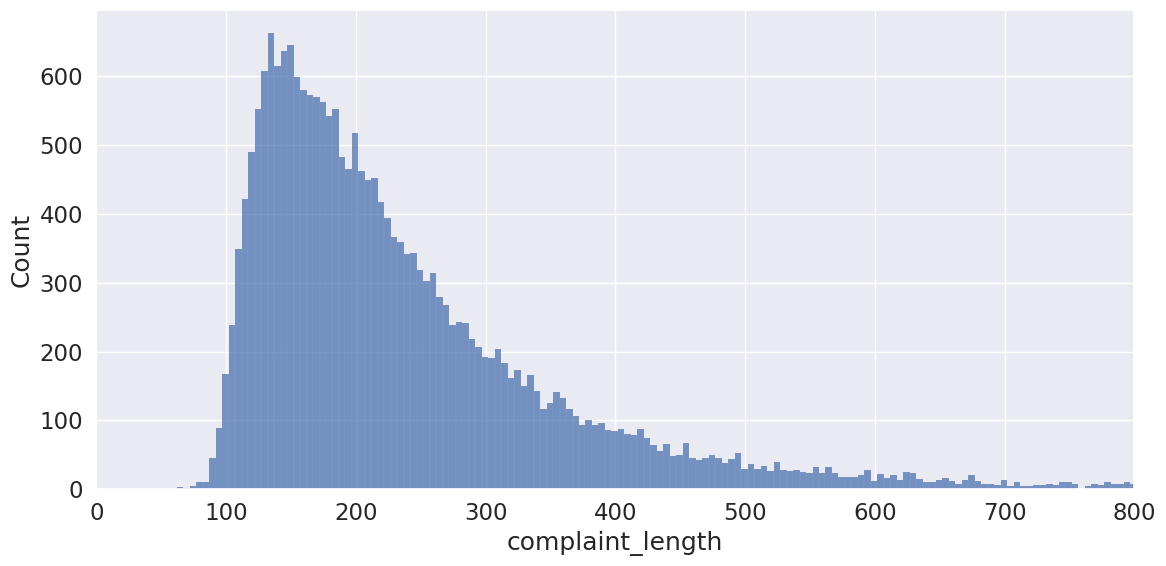

In [ ]:
ax=sns.histplot(x=data['complaint_length'],binwidth=5)
plt.xlim(0, 800)
plt.tight_layout()
plt.show()

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.3, stratify=labels, random_state=42)

# Split the remaining data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

In [ ]:
train_dataset,val_dataset,test_dataset=create_tensors(X_train,X_val,X_test,300,tokenizer)
train_dataloader, validation_dataloader, test_dataloader= create_dataloaders(train_dataset,val_dataset,test_dataset, batch_s=32)

15701
3364
3365


In [ ]:
# https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb#scrollTo=mjJGEXShp7te
from transformers import BertForSequenceClassification
import torch.nn as nn

model = BertForSequenceClassification.from_pretrained(
    "neuralmind/bert-base-portuguese-cased",
    num_labels=4,
    output_attentions=False,
    output_hidden_states=False
)

# Tell PyTorch to run the model on the GPU
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
optimizer1, scheduler1 = set_configs(model, train_dataloader, learning_rate=8.23828987673291e-06, epochs=15, weight_decay=0.07559054336016528)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
torch.cuda.empty_cache()


======== Epoch 1 / 15 ========
Training...
  Batch    50  of    491.    Elapsed: 0:00:28.
  Batch   100  of    491.    Elapsed: 0:00:56.
  Batch   150  of    491.    Elapsed: 0:01:23.
  Batch   200  of    491.    Elapsed: 0:01:51.
  Batch   250  of    491.    Elapsed: 0:02:19.
  Batch   300  of    491.    Elapsed: 0:02:46.
  Batch   350  of    491.    Elapsed: 0:03:14.
  Batch   400  of    491.    Elapsed: 0:03:42.
  Batch   450  of    491.    Elapsed: 0:04:10.

  Average training loss: 1.15
  Training epoch took: 0:04:33

Running Validation...
  Accuracy: 0.62
Saving model
  Validation Loss: 0.99
  Validation took: 0:00:19

======== Epoch 2 / 15 ========
Training...
  Batch    50  of    491.    Elapsed: 0:00:28.
  Batch   100  of    491.    Elapsed: 0:00:56.
  Batch   150  of    491.    Elapsed: 0:01:24.
  Batch   200  of    491.    Elapsed: 0:01:51.
  Batch   250  of    491.    Elapsed: 0:02:19.
  Batch   300  of    491.    Elapsed: 0:02:47.
  Batch   350  of    491.    Elapsed: 0:0

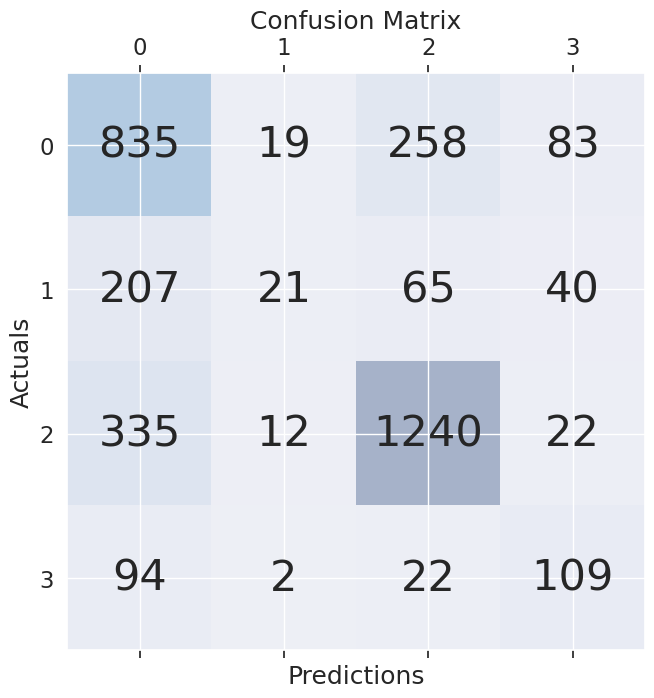



None


In [ ]:
training_stats= train(model, optimizer1, scheduler1, train_dataloader, validation_dataloader, epochs=15)

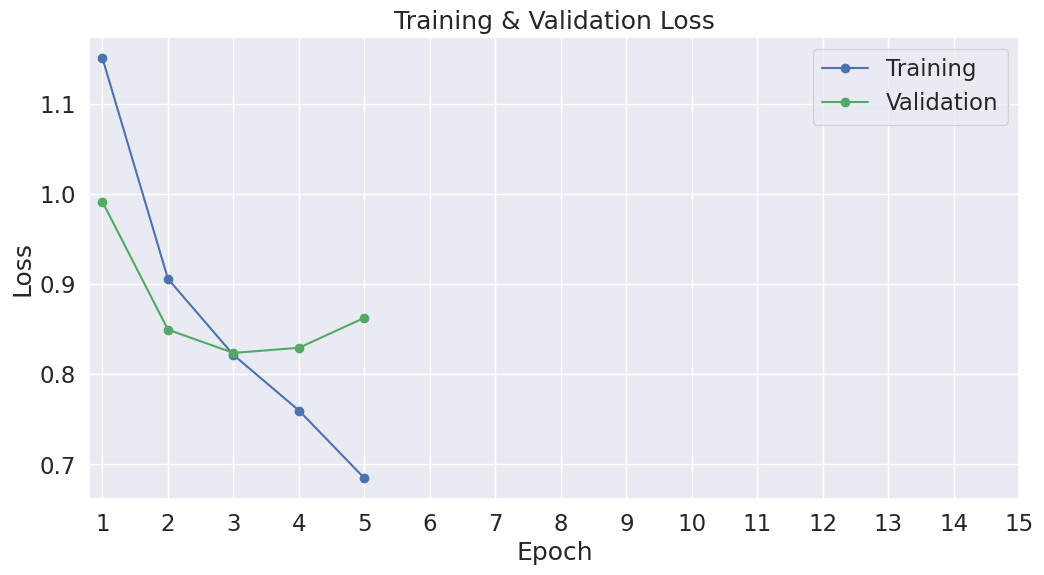

In [ ]:
stats(training_stats,15)

In [ ]:
# Load best model
path='saved_weights_bertimbau.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
predictions, true_labels= test(model, test_dataloader)

Predicting labels for 3,365 test sentences...
    DONE.


In [ ]:
predictions_concatenated = np.concatenate(predictions)
print(len(predictions_concatenated))
true_labels_concatenated = np.concatenate(true_labels)
print(len(true_labels_concatenated))

3365
3365


CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.58      0.67      0.62      1195
           1       1.00      0.00      0.01       333
           2       0.73      0.86      0.79      1609
           3       0.53      0.24      0.33       228

    accuracy                           0.66      3365
   macro avg       0.71      0.44      0.44      3365
weighted avg       0.69      0.66      0.62      3365



CONFUSION MATRIX


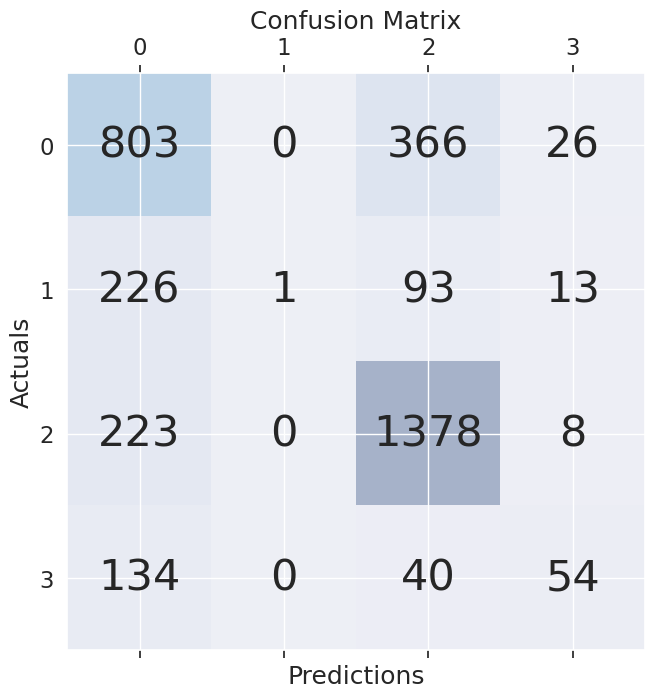

In [ ]:
get_metrics(predictions,true_labels)

# description + title + events + entities

In [ ]:
feature_set=['narrative_bert', 'title', 'events_clean', 'entities']
all = data[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)

In [ ]:
# identify features and target
sentences = all.values
labels = data.reason.values

In [ ]:
# tokenize the text feature
tokenized_feature_raw = tokenizer.batch_encode_plus(
                            # Sentences to encode
                            sentences.tolist(),
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True
                   )
token_sentence_length=[]
# collect tokenized sentence length
for i in range(len(tokenized_feature_raw['input_ids'])):
    token_sentence_length=token_sentence_length+[len(tokenized_feature_raw['input_ids'][i])]

print('max: ', max(token_sentence_length))
print('min: ', min(token_sentence_length))

data['complaint_length'] = token_sentence_length

max:  12003
min:  45


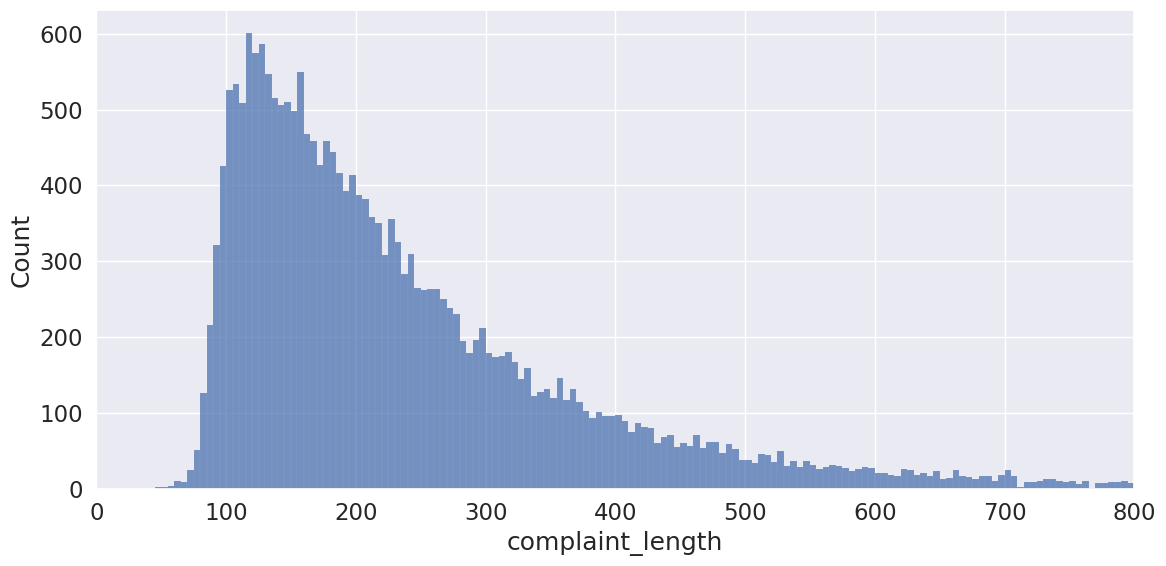

In [ ]:
ax=sns.histplot(x=data['complaint_length'],binwidth=5)
plt.xlim(0, 800)
plt.tight_layout()
plt.show()

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.3, stratify=labels, random_state=42)

# Split the remaining data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

In [ ]:
train_dataset,val_dataset,test_dataset=create_tensors(X_train,X_val,X_test,300,tokenizer)
train_dataloader, validation_dataloader, test_dataloader= create_dataloaders(train_dataset,val_dataset,test_dataset, batch_s=32)

15701
3364
3365


In [ ]:
# https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb#scrollTo=mjJGEXShp7te
from transformers import BertForSequenceClassification
import torch.nn as nn

model = BertForSequenceClassification.from_pretrained(
    "neuralmind/bert-base-portuguese-cased",
    num_labels=4,
    output_attentions=False,
    output_hidden_states=False
)

# Tell PyTorch to run the model on the GPU
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
optimizer1, scheduler1 = set_configs(model, train_dataloader, learning_rate=8.23828987673291e-06, epochs=15, weight_decay=0.07559054336016528)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
torch.cuda.empty_cache()


======== Epoch 1 / 15 ========
Training...
  Batch    50  of    491.    Elapsed: 0:00:28.
  Batch   100  of    491.    Elapsed: 0:00:56.
  Batch   150  of    491.    Elapsed: 0:01:24.
  Batch   200  of    491.    Elapsed: 0:01:51.
  Batch   250  of    491.    Elapsed: 0:02:19.
  Batch   300  of    491.    Elapsed: 0:02:47.
  Batch   350  of    491.    Elapsed: 0:03:15.
  Batch   400  of    491.    Elapsed: 0:03:43.
  Batch   450  of    491.    Elapsed: 0:04:10.

  Average training loss: 1.16
  Training epoch took: 0:04:33

Running Validation...
  Accuracy: 0.63
Saving model
  Validation Loss: 0.97
  Validation took: 0:00:20

======== Epoch 2 / 15 ========
Training...
  Batch    50  of    491.    Elapsed: 0:00:28.
  Batch   100  of    491.    Elapsed: 0:00:56.
  Batch   150  of    491.    Elapsed: 0:01:24.
  Batch   200  of    491.    Elapsed: 0:01:51.
  Batch   250  of    491.    Elapsed: 0:02:19.
  Batch   300  of    491.    Elapsed: 0:02:47.
  Batch   350  of    491.    Elapsed: 0:0

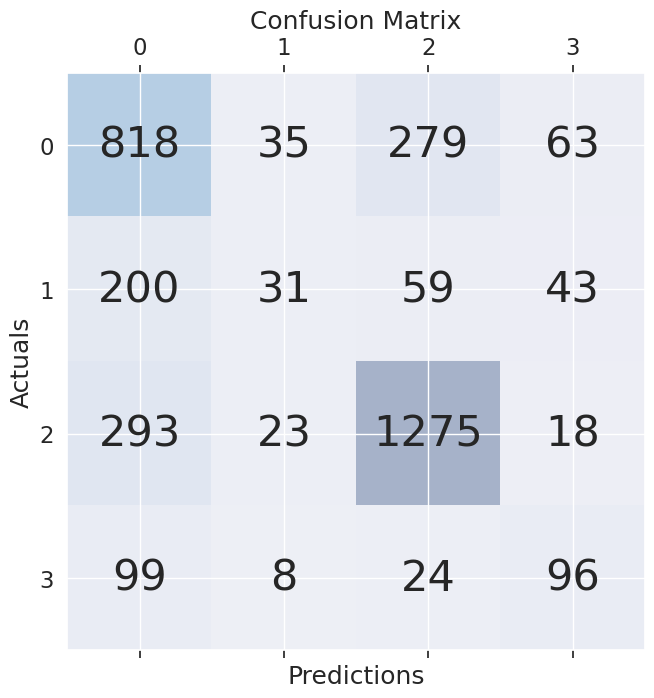



None


In [ ]:
training_stats= train(model, optimizer1, scheduler1, train_dataloader, validation_dataloader, epochs=15)

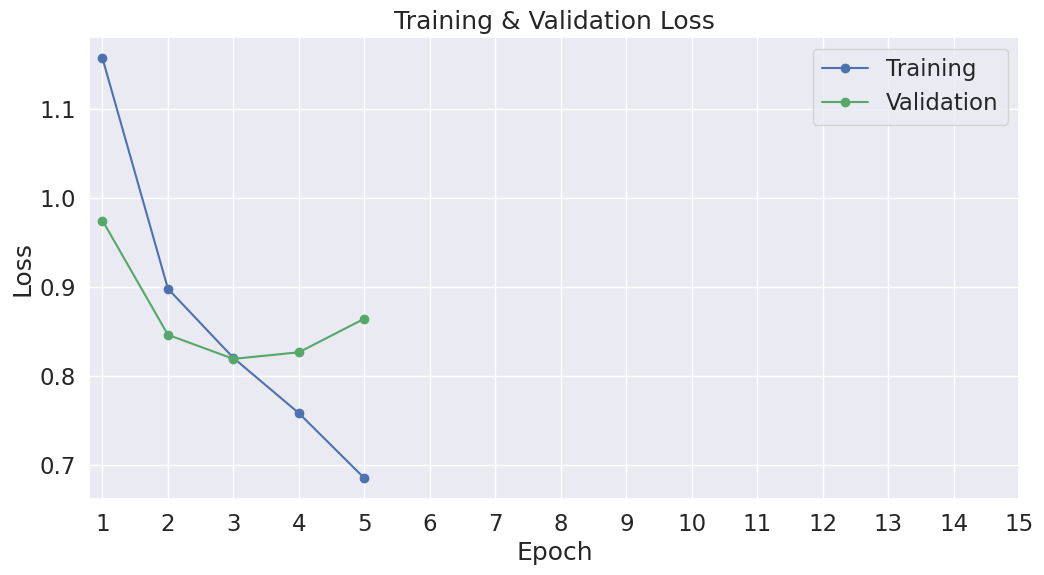

In [ ]:
stats(training_stats,15)

In [ ]:
# Load best model
path='saved_weights_bertimbau.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
predictions, true_labels= test(model, test_dataloader)

Predicting labels for 3,365 test sentences...
    DONE.


In [ ]:
predictions_concatenated = np.concatenate(predictions)
print(len(predictions_concatenated))
true_labels_concatenated = np.concatenate(true_labels)
print(len(true_labels_concatenated))

3365
3365


CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.59      0.62      0.61      1195
           1       0.36      0.02      0.03       333
           2       0.72      0.89      0.79      1609
           3       0.50      0.23      0.32       228

    accuracy                           0.66      3365
   macro avg       0.54      0.44      0.44      3365
weighted avg       0.62      0.66      0.62      3365



CONFUSION MATRIX


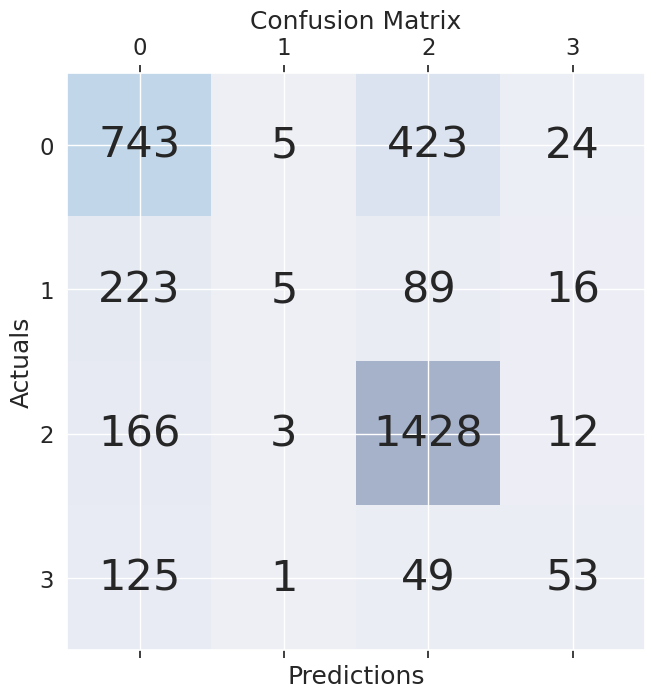

In [ ]:
get_metrics(predictions,true_labels)

# description + title + keywords + events + entities

In [ ]:
feature_set=['narrative_bert', 'title', 'embeddings_keywords', 'events_clean', 'entities']
all = data[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)

In [ ]:
# identify features and target
sentences = all.values
labels = data.reason.values

In [ ]:
# tokenize the text feature
tokenized_feature_raw = tokenizer.batch_encode_plus(
                            # Sentences to encode
                            sentences.tolist(),
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True
                   )
token_sentence_length=[]
# collect tokenized sentence length
for i in range(len(tokenized_feature_raw['input_ids'])):
    token_sentence_length=token_sentence_length+[len(tokenized_feature_raw['input_ids'][i])]

print('max: ', max(token_sentence_length))
print('min: ', min(token_sentence_length))

data['complaint_length'] = token_sentence_length

max:  12033
min:  61


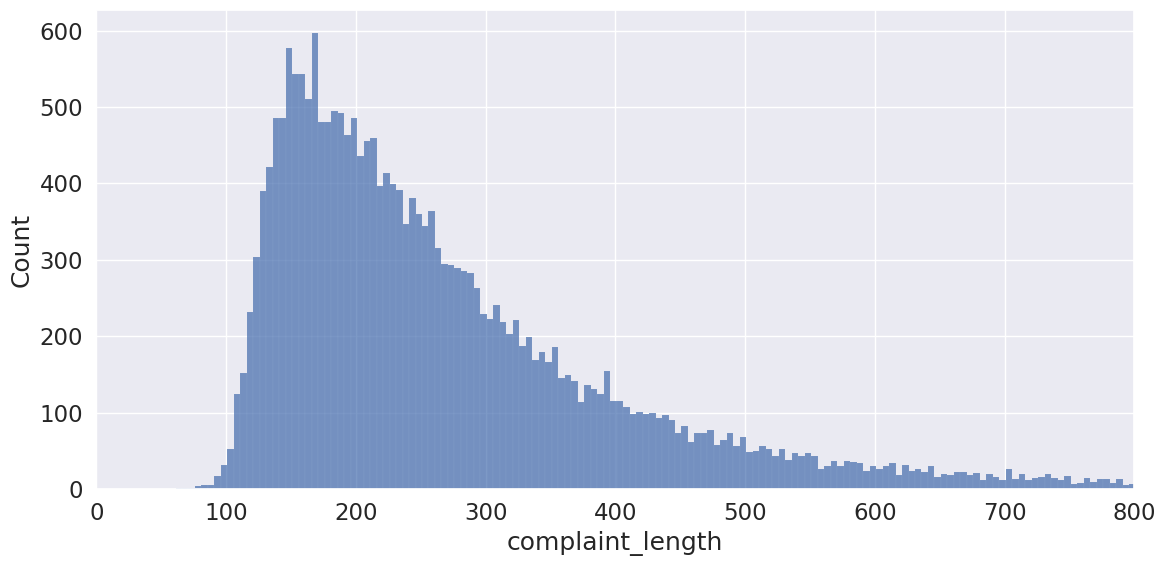

In [ ]:
ax=sns.histplot(x=data['complaint_length'],binwidth=5)
plt.xlim(0, 800)
plt.tight_layout()
plt.show()

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.3, stratify=labels, random_state=42)

# Split the remaining data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

In [ ]:
# https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb#scrollTo=mjJGEXShp7te
from transformers import BertForSequenceClassification
import torch.nn as nn

model = BertForSequenceClassification.from_pretrained(
    "neuralmind/bert-base-portuguese-cased",
    num_labels=4,
    output_attentions=False,
    output_hidden_states=False
)

# Tell PyTorch to run the model on the GPU
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
train_dataset,val_dataset,test_dataset=create_tensors(X_train,X_val,X_test,300,tokenizer)
train_dataloader, validation_dataloader, test_dataloader= create_dataloaders(train_dataset,val_dataset,test_dataset, batch_s=32)

15701
3364
3365


In [ ]:
optimizer1, scheduler1 = set_configs(model, train_dataloader, learning_rate=8.23828987673291e-06, epochs=15, weight_decay=0.07559054336016528)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
torch.cuda.empty_cache()


======== Epoch 1 / 15 ========
Training...
  Batch    50  of    491.    Elapsed: 0:00:28.
  Batch   100  of    491.    Elapsed: 0:00:56.
  Batch   150  of    491.    Elapsed: 0:01:24.
  Batch   200  of    491.    Elapsed: 0:01:52.
  Batch   250  of    491.    Elapsed: 0:02:19.
  Batch   300  of    491.    Elapsed: 0:02:47.
  Batch   350  of    491.    Elapsed: 0:03:15.
  Batch   400  of    491.    Elapsed: 0:03:43.
  Batch   450  of    491.    Elapsed: 0:04:11.

  Average training loss: 1.21
  Training epoch took: 0:04:34

Running Validation...
  Accuracy: 0.62
Saving model
  Validation Loss: 1.00
  Validation took: 0:00:24

======== Epoch 2 / 15 ========
Training...
  Batch    50  of    491.    Elapsed: 0:00:28.
  Batch   100  of    491.    Elapsed: 0:00:56.
  Batch   150  of    491.    Elapsed: 0:01:23.
  Batch   200  of    491.    Elapsed: 0:01:51.
  Batch   250  of    491.    Elapsed: 0:02:19.
  Batch   300  of    491.    Elapsed: 0:02:47.
  Batch   350  of    491.    Elapsed: 0:0

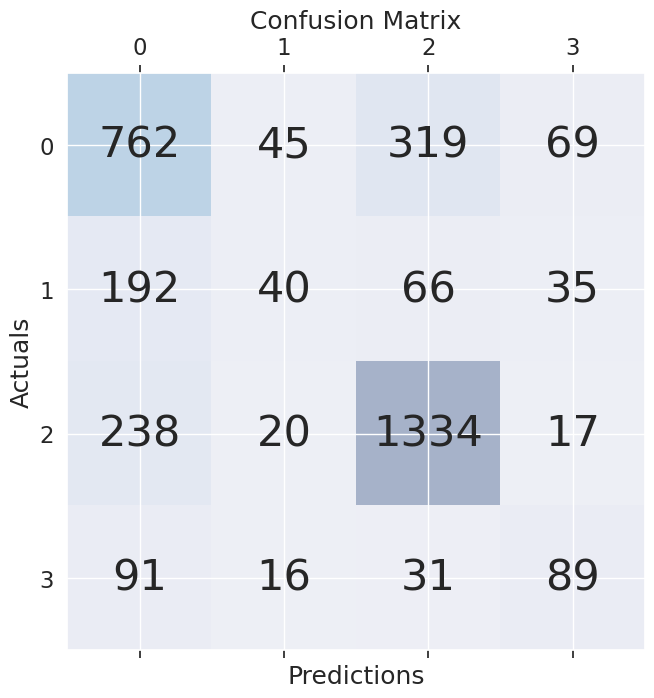



None


In [ ]:
training_stats= train(model, optimizer1, scheduler1, train_dataloader, validation_dataloader, epochs=15)

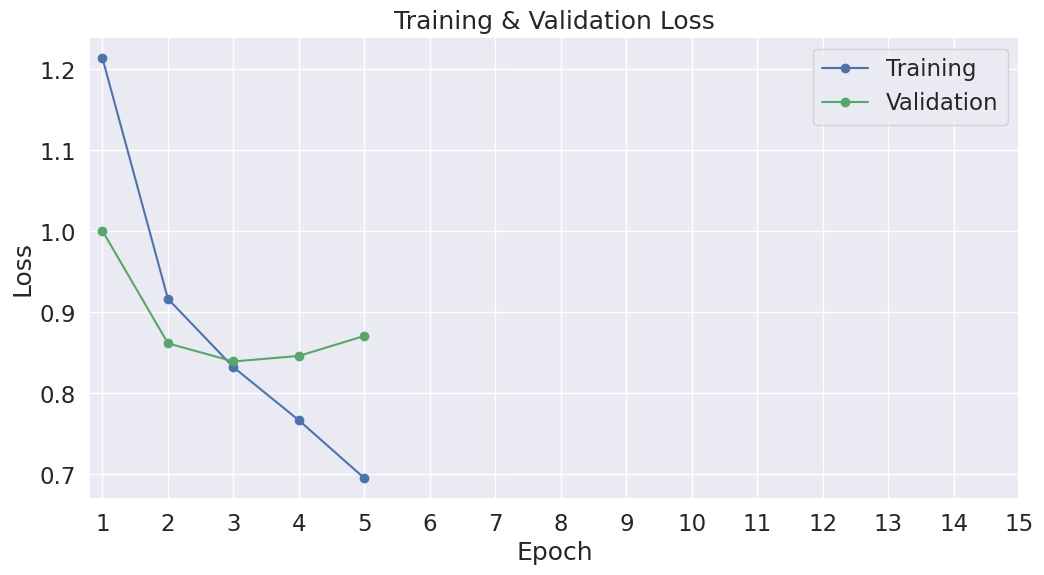

In [ ]:
stats(training_stats,15)

In [ ]:
# Load best model
path='saved_weights_bertimbau.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
predictions, true_labels= test(model, test_dataloader)

Predicting labels for 3,365 test sentences...
    DONE.


In [ ]:
predictions_concatenated = np.concatenate(predictions)
print(len(predictions_concatenated))
true_labels_concatenated = np.concatenate(true_labels)
print(len(true_labels_concatenated))

3365
3365


CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.58      0.61      0.59      1195
           1       1.00      0.01      0.01       333
           2       0.71      0.89      0.79      1609
           3       0.49      0.18      0.26       228

    accuracy                           0.66      3365
   macro avg       0.70      0.42      0.41      3365
weighted avg       0.68      0.66      0.61      3365



CONFUSION MATRIX


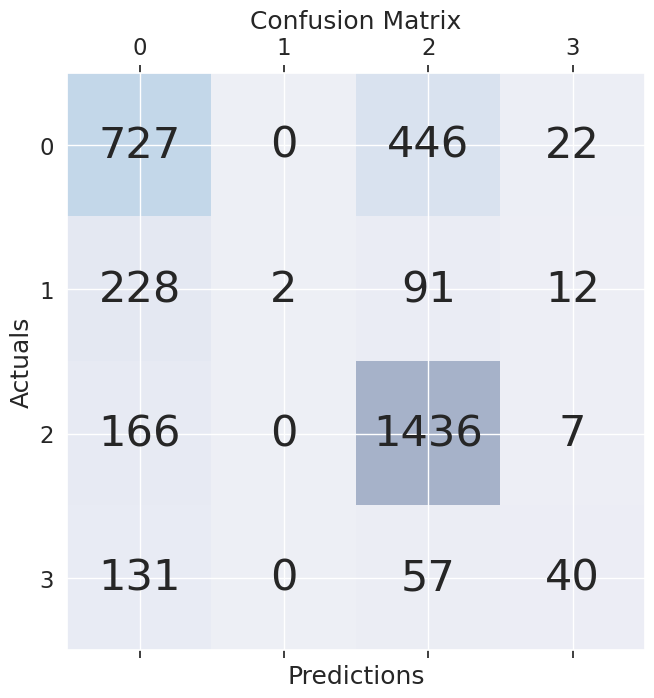

In [ ]:
get_metrics(predictions,true_labels)

# BERT + SMOTE

In [26]:
feature_set = ['narrative_bert','title','events_clean']
narrative_bert_title = data[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)

In [67]:
# identify features and target
sentences = narrative_bert_title.values
labels = data.reason.values

In [68]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.3, stratify=labels, random_state=42)

# Split the remaining data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

In [69]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(random_state=42, sampling_strategy='not majority')

def create_tensors(X_train,X_val,X_test, max_len, tokenizer):
  train_inputs = []
  val_inputs = []
  test_inputs = []

  for sentence in X_train:
      input_ids, attention_mask = tokenize_text(sentence, max_len, tokenizer)
      train_inputs.append((input_ids, attention_mask))

  for sentence in X_val:
      input_ids, attention_mask = tokenize_text(sentence, max_len, tokenizer)
      val_inputs.append((input_ids, attention_mask))

  for sentence in X_test:
      input_ids, attention_mask = tokenize_text(sentence, max_len, tokenizer)
      test_inputs.append((input_ids, attention_mask))

  # Create input tensors and labels
  train_input_ids = torch.cat([t[0] for t in train_inputs], dim=0)
  train_attention_masks = torch.cat([t[1] for t in train_inputs], dim=0)
  train_labels = torch.tensor(y_train)
  # Fit and apply SMOTE to the training data
  X_train_resampled, y_train_resampled = smote.fit_resample(train_input_ids, train_labels)
  X_attention_mask_resampled, _ = smote.fit_resample(train_attention_masks, train_labels)

  val_input_ids = torch.cat([t[0] for t in val_inputs], dim=0)
  val_attention_masks = torch.cat([t[1] for t in val_inputs], dim=0)
  val_labels = torch.tensor(y_val)

  test_input_ids = torch.cat([t[0] for t in test_inputs], dim=0)
  test_attention_masks = torch.cat([t[1] for t in test_inputs], dim=0)
  test_labels = torch.tensor(y_test)

  train_dataset = TensorDataset(X_train_resampled, X_attention_mask_resampled, X_train_resampled)
  val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
  test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)
  return train_dataset,val_dataset,test_dataset

In [70]:
# https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb#scrollTo=mjJGEXShp7te
from transformers import BertForSequenceClassification
import torch.nn as nn

model = BertForSequenceClassification.from_pretrained(
    "neuralmind/bert-base-portuguese-cased",
    num_labels=4,
    output_attentions=False,
    output_hidden_states=False
)

# Tell PyTorch to run the model on the GPU
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [71]:
train_dataset,val_dataset,test_dataset=create_tensors(X_train,X_val,X_test,256,tokenizer)
train_dataloader, validation_dataloader, test_dataloader= create_dataloaders(train_dataset,val_dataset,test_dataset, batch_s=32)

TypeError: ignored

In [ ]:
optimizer1, scheduler1 = set_configs(model, train_dataloader, learning_rate=8.23828987673291e-06, epochs=15, weight_decay=0.07559054336016528)

In [ ]:
training_stats= train(model, optimizer1, scheduler1, train_dataloader, validation_dataloader, epochs=15)

In [ ]:
stats(training_stats,15)

In [ ]:
# Load best model
path='saved_weights_bertimbau.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
predictions, true_labels= test(model, test_dataloader)

Predicting labels for 3,365 test sentences...
    DONE.


In [ ]:
predictions_concatenated = np.concatenate(predictions)
print(len(predictions_concatenated))
true_labels_concatenated = np.concatenate(true_labels)
print(len(true_labels_concatenated))

In [ ]:
get_metrics(predictions,true_labels)

# class weigts + BERT  
https://discuss.huggingface.co/t/class-weights-for-bertforsequenceclassification/1674/7

In [47]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights

array([0.70395445, 2.52752737, 0.52266977, 3.69609228])

In [48]:
import time
import torch
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# # Function to calculate class weights
# def calculate_class_weights(train_labels, num_classes):
#     class_weights = compute_class_weight('balanced', classes=np.arange(num_classes), y=train_labels)
#     class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)

#     return torch.tensor(class_weights, dtype=torch.float32)

def train_with_class_weights(model, optimizer, scheduler, train_dataloader, validation_dataloader, epochs):
  # Calculate class weights for the training data
  # all_labels = []
  # for batch in train_dataloader:
  #     all_labels.extend(batch[2].tolist())
  # num_classes = len(np.unique(all_labels))
  # class_weights = calculate_class_weights(all_labels, num_classes).to(model.device)

  # We'll store a number of quantities such as training and validation loss,
  # validation accuracy, and timings.
  training_stats = []

  # Measure the total training time for the whole run.
  total_t0 = time.time()

  best_val_loss = np.Inf
  patience_counter = 0
  patience_limit = 3

  # For each epoch...
  for epoch_i in range(0, epochs):

      # ========================================
      #               Training
      # ========================================

      # Perform one full pass over the training set.

      print("")
      print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
      print('Training...')

      # Measure how long the training epoch takes.
      t0 = time.time()

      # Reset the total loss for this epoch.
      total_train_loss = 0

      valid_loss_min = np.Inf

      model.train()

      # For each batch of training data...
      for step, batch in enumerate(train_dataloader):

          # Progress update every 50 batches.
          if step % 50 == 0 and not step == 0:
              # Calculate elapsed time in minutes.
              elapsed = format_time(time.time() - t0)

              # Report progress.
              print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

          # Unpack this training batch from our dataloader.
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)

          # Always clear any previously calculated gradients before performing a
          # backward pass.
          model.zero_grad()

          # Perform a forward pass (evaluate the model on this training batch).
          result = model(b_input_ids,
                          token_type_ids=None,
                          attention_mask=b_input_mask,
                          labels=b_labels,
                          return_dict=True)

          loss = result.loss
          logits = result.logits

          # Create a weight tensor to apply class weights
          weights = torch.tensor(class_weights, dtype=torch.float32).to(model.device)

          # Define the loss function with class weights
          loss_fn = torch.nn.CrossEntropyLoss(weight=weights)

          # Calculate the loss
          loss = loss_fn(logits, b_labels)

          # Accumulate the training loss over all of the batches so that we can
          # calculate the average loss at the end. `loss` is a Tensor containing a
          # single value; the `.item()` function just returns the Python value
          # from the tensor.
          total_train_loss += loss.item()

          # Perform a backward pass to calculate the gradients.
          loss.backward()

          # Clip the norm of the gradients to 1.0.
          # This is to help prevent the "exploding gradients" problem.
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          # Update parameters and take a step using the computed gradient.
          optimizer.step()

          # Update the learning rate.
          scheduler.step()

      # Calculate the average loss over all of the batches.
      avg_train_loss = total_train_loss / len(train_dataloader)

      # Measure how long this epoch took.
      training_time = format_time(time.time() - t0)

      print("")
      print("  Average training loss: {0:.2f}".format(avg_train_loss))
      print("  Training epoch took: {:}".format(training_time))

      # ========================================
      #               Validation
      # ========================================
      # After the completion of each training epoch, measure our performance on
      # our validation set.

      print("")
      print("Running Validation...")

      t0 = time.time()

      # Put the model in evaluation mode
      model.eval()

      # Tracking variables
      total_eval_accuracy = 0
      total_eval_loss = 0
      nb_eval_steps = 0
      predictions, true_labels=[],[]

      # Evaluate data for one epoch
      for batch in validation_dataloader:

          # Unpack this training batch from our dataloader.
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)

          # Tell pytorch not to bother with constructing the compute graph during
          # the forward pass, since this is only needed for backprop (training).
          with torch.no_grad():

              # Forward pass, calculate logit predictions.
              result = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels=b_labels,
                            return_dict=True)

          # Get the loss and "logits" output by the model. The "logits" are the
          # output values prior to applying an activation function like the
          # softmax.
          loss = result.loss
          logits = result.logits

          # Accumulate the validation loss.
          total_eval_loss += loss.item()

          # Move logits and labels to CPU
          logits = logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()


          # Calculate the accuracy for this batch of test sentences, and
          # accumulate it over all batches.
          total_eval_accuracy += flat_accuracy(logits, label_ids)

          predictions.append(logits)
          true_labels.append(label_ids)

      # Report the final accuracy for this validation run.
      avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
      print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

      # Calculate the average loss over all of the batches.
      avg_val_loss = total_eval_loss / len(validation_dataloader)

      # Early stopping check
      if avg_val_loss < best_val_loss:
          print('Saving model')
          torch.save(model.state_dict(), 'saved_weights_bertimbau.pt')
          best_val_loss = avg_val_loss
          patience_counter = 0
      else:
          patience_counter += 1

      if patience_counter >= patience_limit:
          print(f'Early stopping at epoch {epoch_i+1} due to no improvement in validation loss.')
          break

      # Measure how long the validation run took.
      validation_time = format_time(time.time() - t0)

      print("  Validation Loss: {0:.2f}".format(avg_val_loss))
      print("  Validation took: {:}".format(validation_time))

      # Record all statistics from this epoch.
      training_stats.append(
          {
              'epoch': epoch_i + 1,
              'Training Loss': avg_train_loss,
              'Valid. Loss': avg_val_loss,
              'Valid. Accur.': avg_val_accuracy,
              'Training Time': training_time,
              'Validation Time': validation_time
          }
      )

  print("")
  print("Training complete!")

  print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
  print("Validation statistics \n")
  print(get_metrics(predictions,true_labels))
  return training_stats


In [49]:
feature_set = ['narrative_bert','title','events_clean']
narrative_bert_title = data[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)

In [50]:
# identify features and target
sentences = narrative_bert_title.values
labels = data.reason.values

In [51]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.3, stratify=labels, random_state=42)

# Split the remaining data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

In [52]:
# https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb#scrollTo=mjJGEXShp7te
from transformers import BertForSequenceClassification
import torch.nn as nn

model = BertForSequenceClassification.from_pretrained(
    "neuralmind/bert-base-portuguese-cased",
    num_labels=4,
    output_attentions=False,
    output_hidden_states=False
)

# Tell PyTorch to run the model on the GPU
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [53]:
train_dataset,val_dataset,test_dataset=create_tensors(X_train,X_val,X_test,256,tokenizer)
train_dataloader, validation_dataloader, test_dataloader= create_dataloaders(train_dataset,val_dataset,test_dataset, batch_s=32)

15701
3364
3365


In [54]:
optimizer1, scheduler1 = set_configs(model, train_dataloader, learning_rate=8.23828987673291e-06, epochs=15, weight_decay=0.07559054336016528)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



======== Epoch 1 / 15 ========
Training...
  Batch    50  of    491.    Elapsed: 0:00:19.
  Batch   100  of    491.    Elapsed: 0:00:38.
  Batch   150  of    491.    Elapsed: 0:00:57.
  Batch   200  of    491.    Elapsed: 0:01:17.
  Batch   250  of    491.    Elapsed: 0:01:36.
  Batch   300  of    491.    Elapsed: 0:01:55.
  Batch   350  of    491.    Elapsed: 0:02:14.
  Batch   400  of    491.    Elapsed: 0:02:33.
  Batch   450  of    491.    Elapsed: 0:02:52.

  Average training loss: 1.37
  Training epoch took: 0:03:08

Running Validation...
  Accuracy: 0.55
Saving model
  Validation Loss: 1.25
  Validation took: 0:00:13

======== Epoch 2 / 15 ========
Training...
  Batch    50  of    491.    Elapsed: 0:00:19.
  Batch   100  of    491.    Elapsed: 0:00:38.
  Batch   150  of    491.    Elapsed: 0:00:57.
  Batch   200  of    491.    Elapsed: 0:01:17.
  Batch   250  of    491.    Elapsed: 0:01:36.
  Batch   300  of    491.    Elapsed: 0:01:55.
  Batch   350  of    491.    Elapsed: 0:0

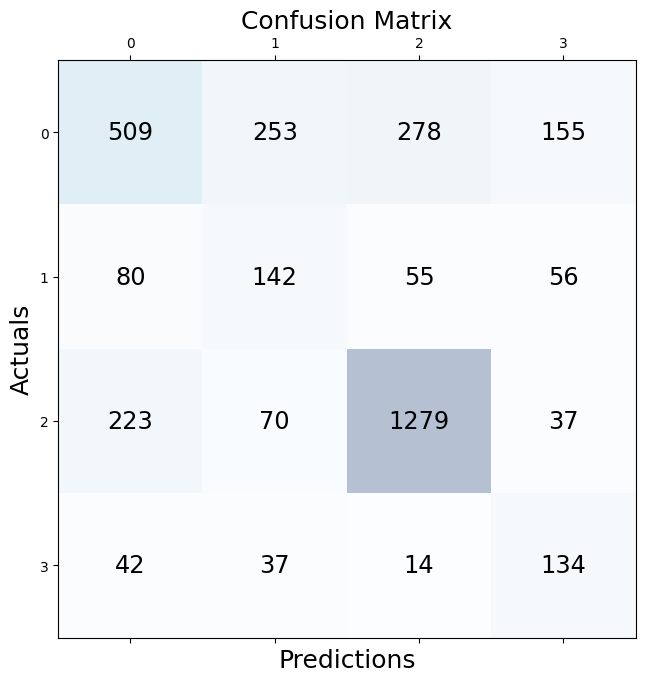



None


In [55]:
training_stats= train_with_class_weights(model, optimizer1, scheduler1, train_dataloader, validation_dataloader, epochs=15)

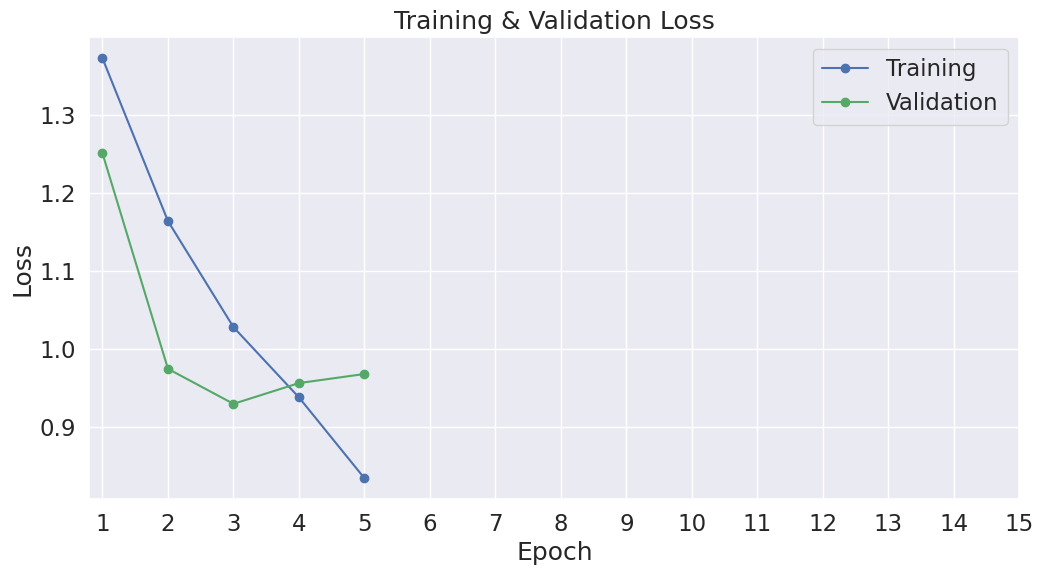

In [56]:
stats(training_stats,15)

In [57]:
# Load best model
path='saved_weights_bertimbau.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [58]:
predictions, true_labels= test(model, test_dataloader)

Predicting labels for 3,365 test sentences...
    DONE.


In [59]:
predictions_concatenated = np.concatenate(predictions)
print(len(predictions_concatenated))
true_labels_concatenated = np.concatenate(true_labels)
print(len(true_labels_concatenated))

3365
3365


CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.62      0.39      0.48      1195
           1       0.30      0.37      0.33       333
           2       0.75      0.83      0.79      1609
           3       0.31      0.60      0.41       228

    accuracy                           0.61      3365
   macro avg       0.50      0.55      0.50      3365
weighted avg       0.63      0.61      0.61      3365



CONFUSION MATRIX


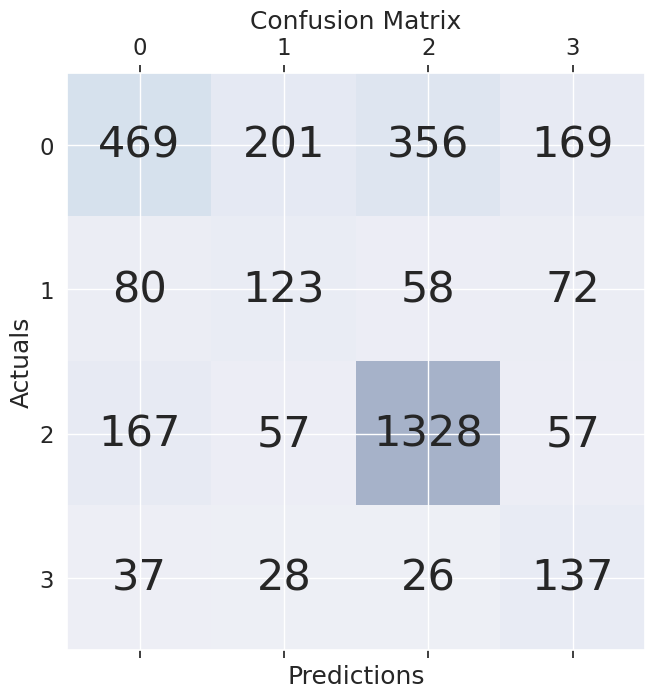

In [60]:
get_metrics(predictions,true_labels)

# SMOTE + class weights + BERT